In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import seaborn as sns

In [3]:
# import data

train = pd.read_csv('/min_train.csv')
val = pd.read_csv('/min_val.csv')
test = pd.read_csv('/min_test.csv')
test2 = pd.read_csv('/min_test2.csv')

In [4]:
train.head()

DateTime_Minute  Bid1_Price  Bid1_Volume  Ask1_Price  Ask1_Volume  \
0  2025-01-02 07:30:00      261.84         3384      270.01         2157   
1  2025-01-02 07:31:00      258.68         2404      263.96         1629   
2  2025-01-02 07:32:00      263.10         2600      267.75         2118   
3  2025-01-02 07:33:00      263.02         2006      267.20         2116   
4  2025-01-02 07:34:00      263.18         3363      268.68         2465   

   Bid2_Price  Bid2_Volume  Ask2_Price  Ask2_Volume  Mid_Price  ...  \
0      254.58         2721      274.22         2231     265.93  ...   
1      254.83         2480      283.13         1758     261.32  ...   
2      260.42         3219      271.33         1721     265.43  ...   
3      260.79         2917      269.99         1979     265.11  ...   
4      260.36         3879      273.01         2472     265.93  ...   

   Highest_Price  Trade_Volume  Price_Mean  RSI      MACD  MACD_signal  \
0         270.00            62      263.21  NaN  0.000000     0.000000   
1         267.00           103      260.39  NaN  0.319088     0.063818   
2         268.67            89      263.94  NaN  0.645222     0.180099   
3         269.00            86      263.11  NaN  0.494527     0.242984   
4         270.00            78      263.75  NaN  1.009001     0.396188   

   MACD_hist  KDJ_K  KDJ_D  KDJ_J  
0   0.000000    NaN    NaN    NaN  
1   0.255271    NaN    NaN    NaN  
2   0.465123    NaN    NaN    NaN  
3   0.251542    NaN    NaN    NaN  
4   0.612814    NaN    NaN    NaN  

[5 rows x 31 columns]

In [5]:
# select mid-price

train_mp = train['Mid_Price']
val_mp = val['Mid_Price']
test_mp = test['Mid_Price']
test2_mp = test2['Mid_Price']

In [6]:
# normalising

train_mean = train_mp.mean()
train_std = train_mp.std()

train_nr = (train_mp - train_mean)/train_std
val_nr = (val_mp - train_mean)/train_std
test_nr = (test_mp - train_mean)/train_std

In [7]:
def create_sequences(data, input_sequence_length, forecast_horizon):
    X, y = [], []
    for i in range(len(data) - input_sequence_length - forecast_horizon + 1):
        X.append(data[i:(i + input_sequence_length)])
        y.append(data[(i + input_sequence_length):(i + input_sequence_length + forecast_horizon)])
    return np.array(X), np.array(y)

In [8]:
input_sequence_length = 20
forecast_horizon = 5

X_train, y_train = create_sequences(train_nr, input_sequence_length, forecast_horizon)
X_val, y_val = create_sequences(val_nr, input_sequence_length, forecast_horizon)
X_test, y_test = create_sequences(test_nr, input_sequence_length, forecast_horizon)

# Display the shape of the created sequences for verification
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((42293, 20), (42293, 5), (10176, 20), (10176, 5), (10686, 20), (10686, 5))

In [9]:
# change the shape to fit the LSTM model

X_train = X_train[:, :, np.newaxis]
X_val = X_val[:, :, np.newaxis]
X_test = X_test[:, :, np.newaxis]


y_train = y_train[:, :, np.newaxis]
y_val = y_val[:, :, np.newaxis]
y_test = y_test[:, :, np.newaxis]

# Display the shape of the created sequences for verification
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((42293, 20, 1),
 (42293, 5, 1),
 (10176, 20, 1),
 (10176, 5, 1),
 (10686, 20, 1),
 (10686, 5, 1))

In [10]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))


train_dataset = train_dataset.batch(32)

val_dataset = val_dataset.batch(32)

test_dataset = test_dataset.batch(32)


In [11]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential

In [12]:
# single layer lstm with 150 unit

OUT_STEPS = 5
num_features = 1

lstm_model_0 = Sequential([
    layers.LSTM(150, dropout=0.2),
    layers.Dense(OUT_STEPS*num_features, kernel_initializer = tf.initializers.zeros()),

    layers.Reshape([OUT_STEPS, num_features])
])

lstm_model_0.build((None, 15, 1))  # 'None' can be used for batch size flexibility
lstm_model_0.summary()  # Now this should work without throwing an error


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 150)               91200     
                                                                 
 dense (Dense)               (None, 5)                 755       
                                                                 
 reshape (Reshape)           (None, 5, 1)              0         
                                                                 
Total params: 91955 (359.20 KB)
Trainable params: 91955 (359.20 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [13]:
lstm_model_0.compile(loss='mse',
              optimizer=Adam(learning_rate=0.001),
              metrics=['mean_absolute_percentage_error'])

In [14]:
history = lstm_model_0.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)]
)

Epoch 1/100
1322/1322 [==============================] - 32s 22ms/step - loss: 0.0402 - mean_absolute_percentage_error: 53.0912 - val_loss: 0.0408 - val_mean_absolute_percentage_error: 16.0438
Epoch 2/100
1322/1322 [==============================] - 29s 22ms/step - loss: 0.0213 - mean_absolute_percentage_error: 47.3573 - val_loss: 0.0693 - val_mean_absolute_percentage_error: 18.3690
Epoch 3/100
1322/1322 [==============================] - 29s 22ms/step - loss: 0.0190 - mean_absolute_percentage_error: 46.7041 - val_loss: 0.0651 - val_mean_absolute_percentage_error: 17.9746
Epoch 4/100
1322/1322 [==============================] - 28s 22ms/step - loss: 0.0182 - mean_absolute_percentage_error: 46.0516 - val_loss: 0.0882 - val_mean_absolute_percentage_error: 20.7080
Epoch 5/100
1322/1322 [==============================] - 28s 21ms/step - loss: 0.0178 - mean_absolute_percentage_error: 46.1447 - val_loss: 0.0775 - val_mean_absolute_percentage_error: 19.8983
Epoch 6/100
1322/1322 [============

In [18]:
# create a function that can plot all these graphs in one action
# plot the result on train val and test


def plot_results(X_train,X_val,X_test,y_train,y_val,y_test, model):
    # Creating indices for plotting
    train_x = np.arange(len(y_train))
    val_x = np.arange(len(y_val))
    test_x = np.arange(len(y_test))

    # Making predictions
    pred_train = model.predict(X_train)
    pred_val = model.predict(X_val)
    pred_test = model.predict(X_test)

    # Creating a figure and subplots
    plt.figure(figsize=(20, 15))  # Adjusted for better vertical display

    # Subplot for the training set
    plt.subplot(3, 1, 1)  # 3 rows, 1 column, 1st subplot
    plt.plot(train_x, y_train[:, 0], label='Actual')
    plt.plot(train_x, pred_train[:, 0], label='Predicted')
    plt.title('Training Set')
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.legend()

    # Subplot for the validation set
    plt.subplot(3, 1, 2)  # 3 rows, 1 column, 2nd subplot
    plt.plot(val_x, y_val[:, 0], label='Actual')
    plt.plot(val_x, pred_val[:, 0], label='Predicted')
    plt.title('Validation Set')
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.legend()

    # Subplot for the test set
    plt.subplot(3, 1, 3)  # 3 rows, 1 column, 3rd subplot
    plt.plot(test_x, y_test[:, 0], label='Actual')
    plt.plot(test_x, pred_test[:, 0], label='Predicted')
    plt.title('Test Set')
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.legend()

    # Show plot
    plt.tight_layout()
    plt.show()

334/334 [==============================] - 3s 9ms/step


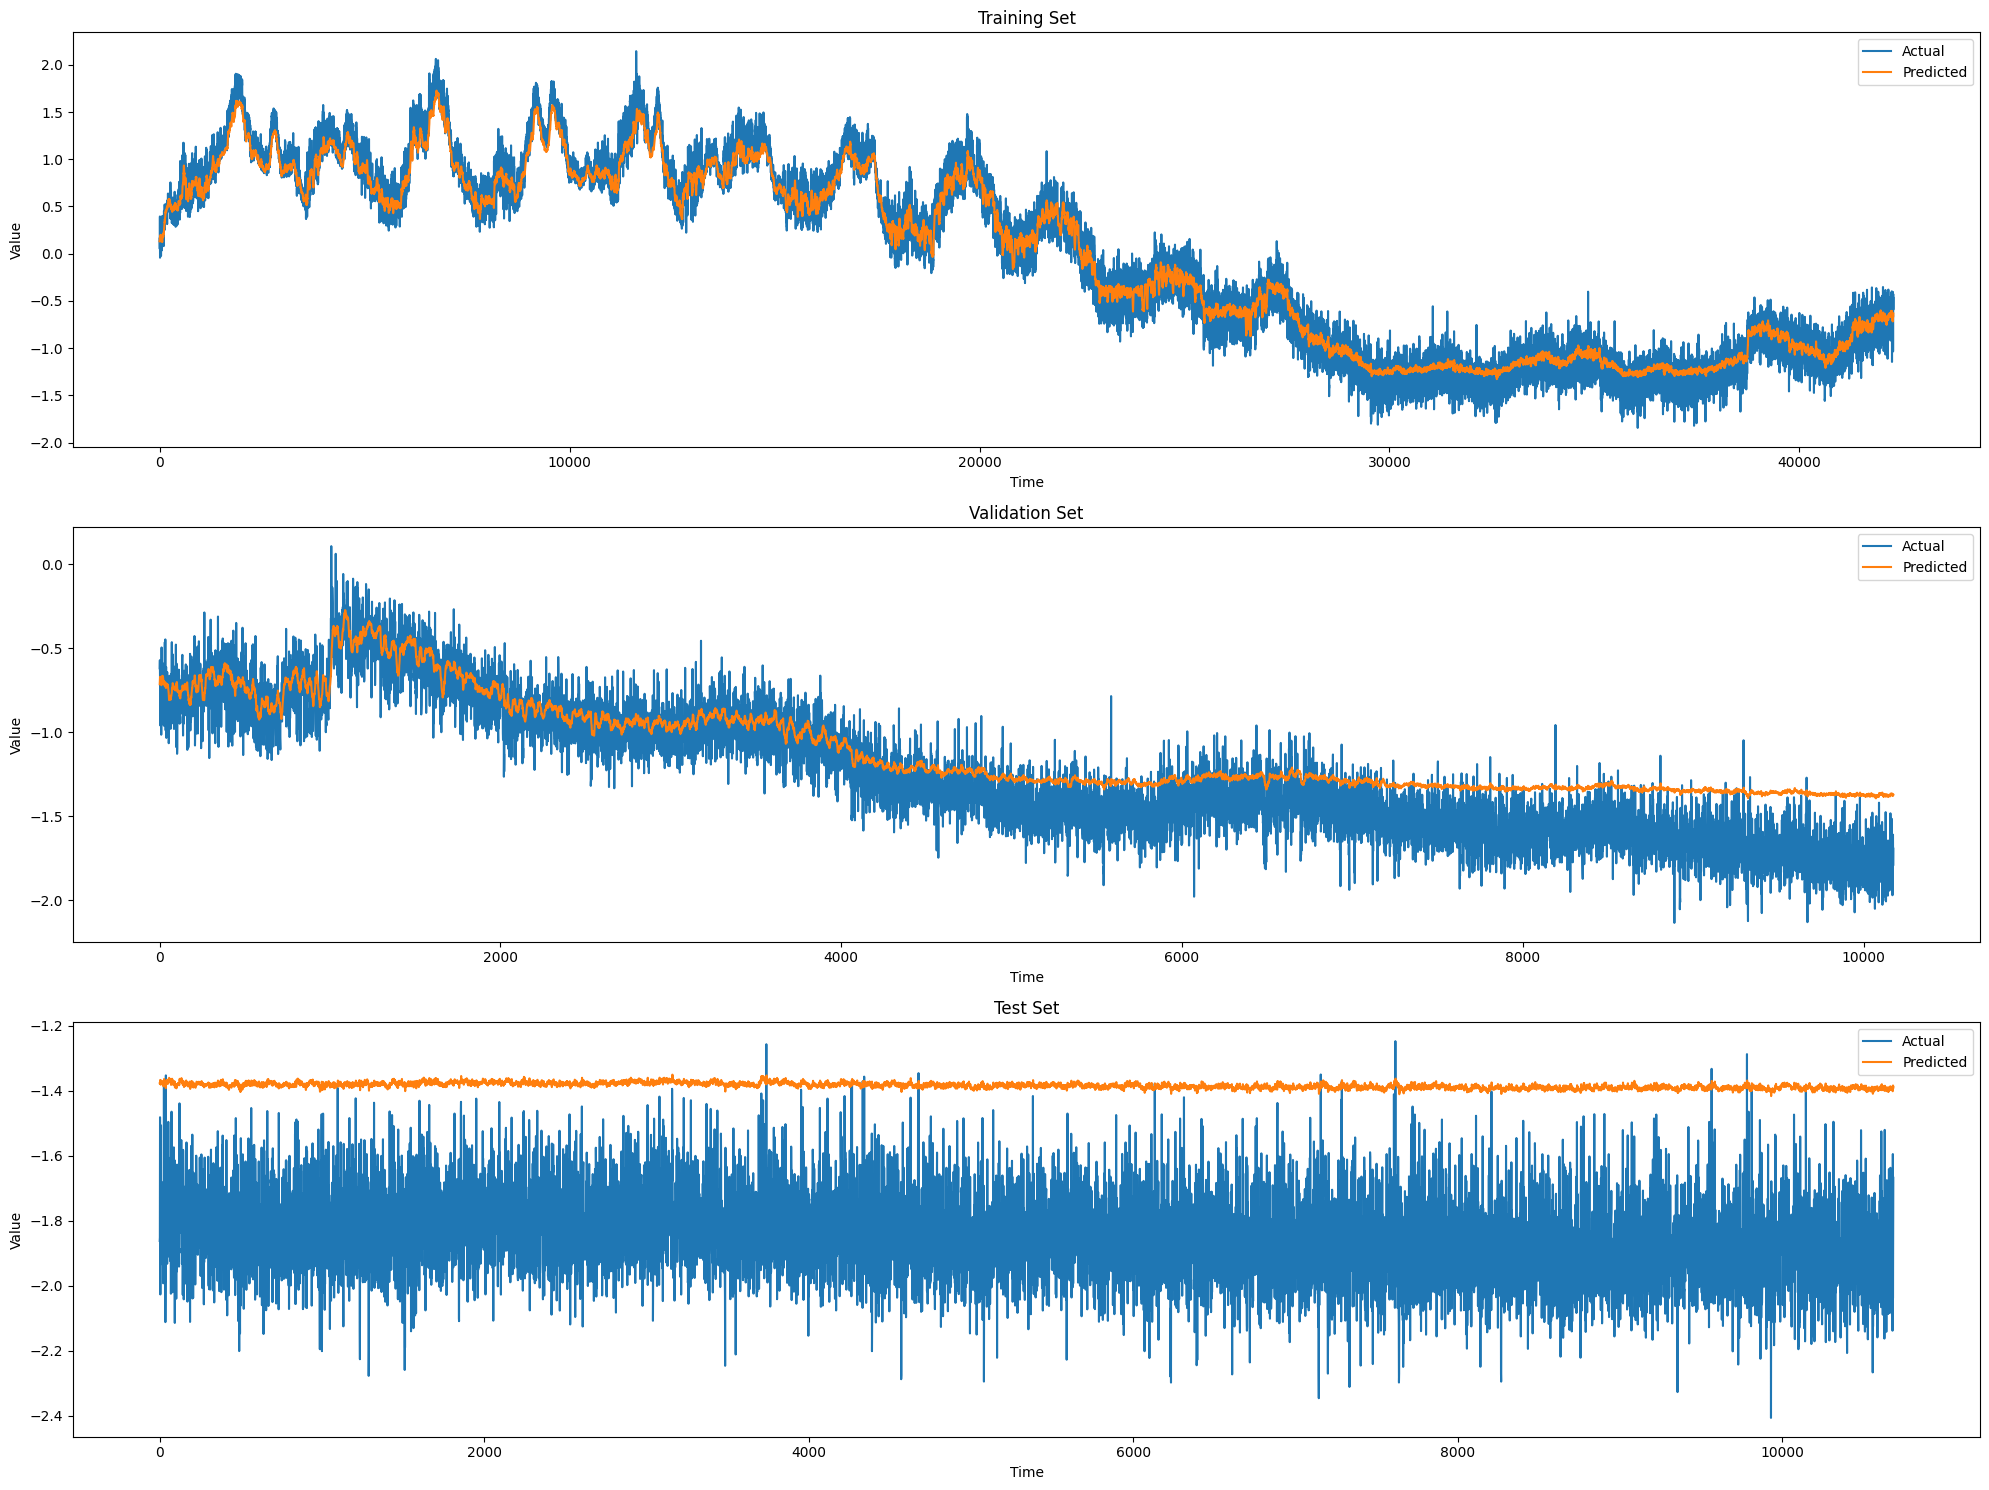

In [ ]:
plot_results(X_train,X_val,X_test,y_train,y_val,y_test, lstm_model_0)

In [ ]:
# same structure without drop out

lstm_model_1 = Sequential([
    layers.LSTM(150),
    layers.Dense(OUT_STEPS*num_features, kernel_initializer = tf.initializers.zeros()),

    layers.Reshape([OUT_STEPS, num_features])
])

lstm_model_1.build((None, 15, 1))  # 'None' can be used for batch size flexibility
lstm_model_1.summary()  # Now this should work without throwing an error


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 150)               91200     
                                                                 
 dense_2 (Dense)             (None, 5)                 755       
                                                                 
 reshape_2 (Reshape)         (None, 5, 1)              0         
                                                                 
Total params: 91955 (359.20 KB)
Trainable params: 91955 (359.20 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
lstm_model_1.compile(loss='mse',
              optimizer=Adam(learning_rate=0.001),
              metrics=['mean_absolute_percentage_error'])

In [ ]:
history = lstm_model_1.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)]
)

Epoch 1/100
1322/1322 [==============================] - 34s 24ms/step - loss: 0.0290 - mean_absolute_percentage_error: 50.5428 - val_loss: 0.0212 - val_mean_absolute_percentage_error: 11.6086
Epoch 2/100
1322/1322 [==============================] - 32s 24ms/step - loss: 0.0168 - mean_absolute_percentage_error: 42.2725 - val_loss: 0.0221 - val_mean_absolute_percentage_error: 11.8662
Epoch 3/100
1322/1322 [==============================] - 32s 24ms/step - loss: 0.0167 - mean_absolute_percentage_error: 41.9645 - val_loss: 0.0241 - val_mean_absolute_percentage_error: 12.0593
Epoch 4/100
1322/1322 [==============================] - 32s 24ms/step - loss: 0.0164 - mean_absolute_percentage_error: 42.1447 - val_loss: 0.0254 - val_mean_absolute_percentage_error: 12.0865
Epoch 5/100
1322/1322 [==============================] - 34s 26ms/step - loss: 0.0164 - mean_absolute_percentage_error: 41.7574 - val_loss: 0.0225 - val_mean_absolute_percentage_error: 12.1924
Epoch 6/100
1322/1322 [============

334/334 [==============================] - 3s 10ms/step


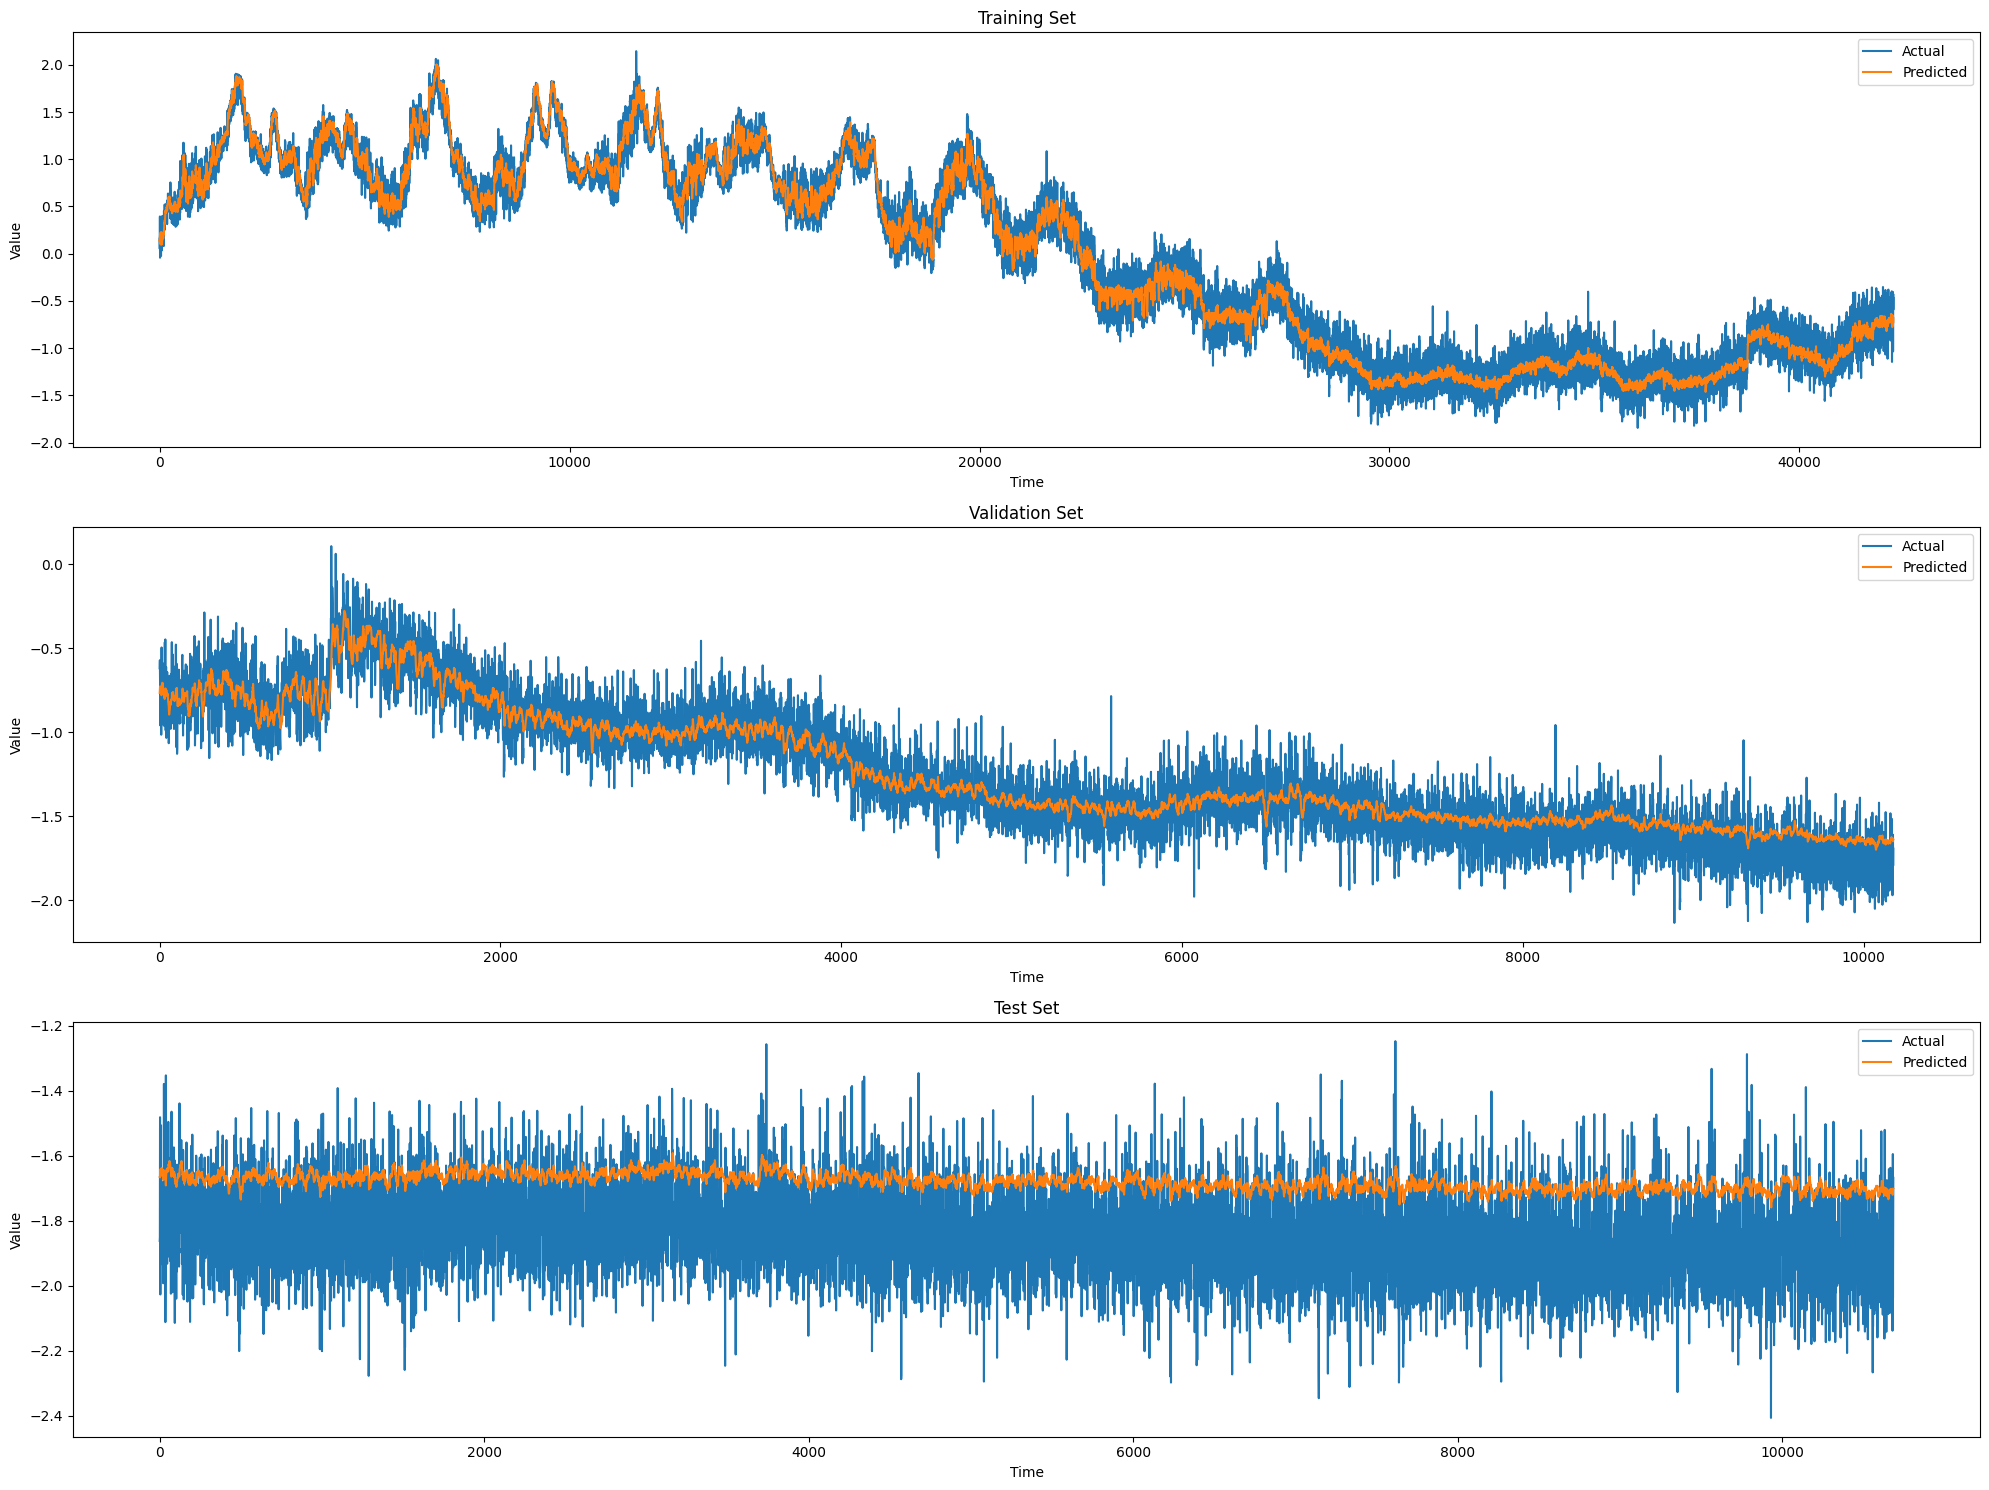

In [ ]:
plot_results(X_train,X_val,X_test,y_train,y_val,y_test, lstm_model_1)

In [ ]:
# deeper structure

lstm_model_d = Sequential([
    layers.LSTM(150, return_sequences=True),
    layers.LSTM(320, dropout=0.2, return_sequences=True),
    layers.LSTM(150),
    layers.Dense(OUT_STEPS*num_features, kernel_initializer = tf.initializers.zeros()),

    layers.Reshape([OUT_STEPS, num_features])
])

lstm_model_d.build((None, 15, 1))  # 'None' can be used for batch size flexibility
lstm_model_d.summary()  # Now this should work without throwing an error


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 150)               91200     
                                                                 
 dense_2 (Dense)             (None, 5)                 755       
                                                                 
 reshape_2 (Reshape)         (None, 5, 1)              0         
                                                                 
Total params: 91955 (359.20 KB)
Trainable params: 91955 (359.20 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
lstm_model_d.compile(loss='mse',
              optimizer=Adam(learning_rate=0.001),
              metrics=['mean_absolute_percentage_error'])

In [ ]:
history = lstm_model_d.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)]
)

Epoch 1/100
1322/1322 [==============================] - 168s 122ms/step - loss: 0.0571 - mean_absolute_percentage_error: 54.9874 - val_loss: 0.0586 - val_mean_absolute_percentage_error: 16.3340
Epoch 2/100
1322/1322 [==============================] - 158s 119ms/step - loss: 0.0191 - mean_absolute_percentage_error: 45.4454 - val_loss: 0.0367 - val_mean_absolute_percentage_error: 13.3702
Epoch 3/100
1322/1322 [==============================] - 157s 119ms/step - loss: 0.0181 - mean_absolute_percentage_error: 44.5794 - val_loss: 0.0397 - val_mean_absolute_percentage_error: 13.8166
Epoch 4/100
1322/1322 [==============================] - 157s 119ms/step - loss: 0.0179 - mean_absolute_percentage_error: 43.6060 - val_loss: 0.0428 - val_mean_absolute_percentage_error: 14.6401
Epoch 5/100
1322/1322 [==============================] - 158s 119ms/step - loss: 0.0175 - mean_absolute_percentage_error: 43.3321 - val_loss: 0.0458 - val_mean_absolute_percentage_error: 14.7639
Epoch 6/100
1322/1322 [==

KeyboardInterrupt: 

334/334 [==============================] - 13s 40ms/step


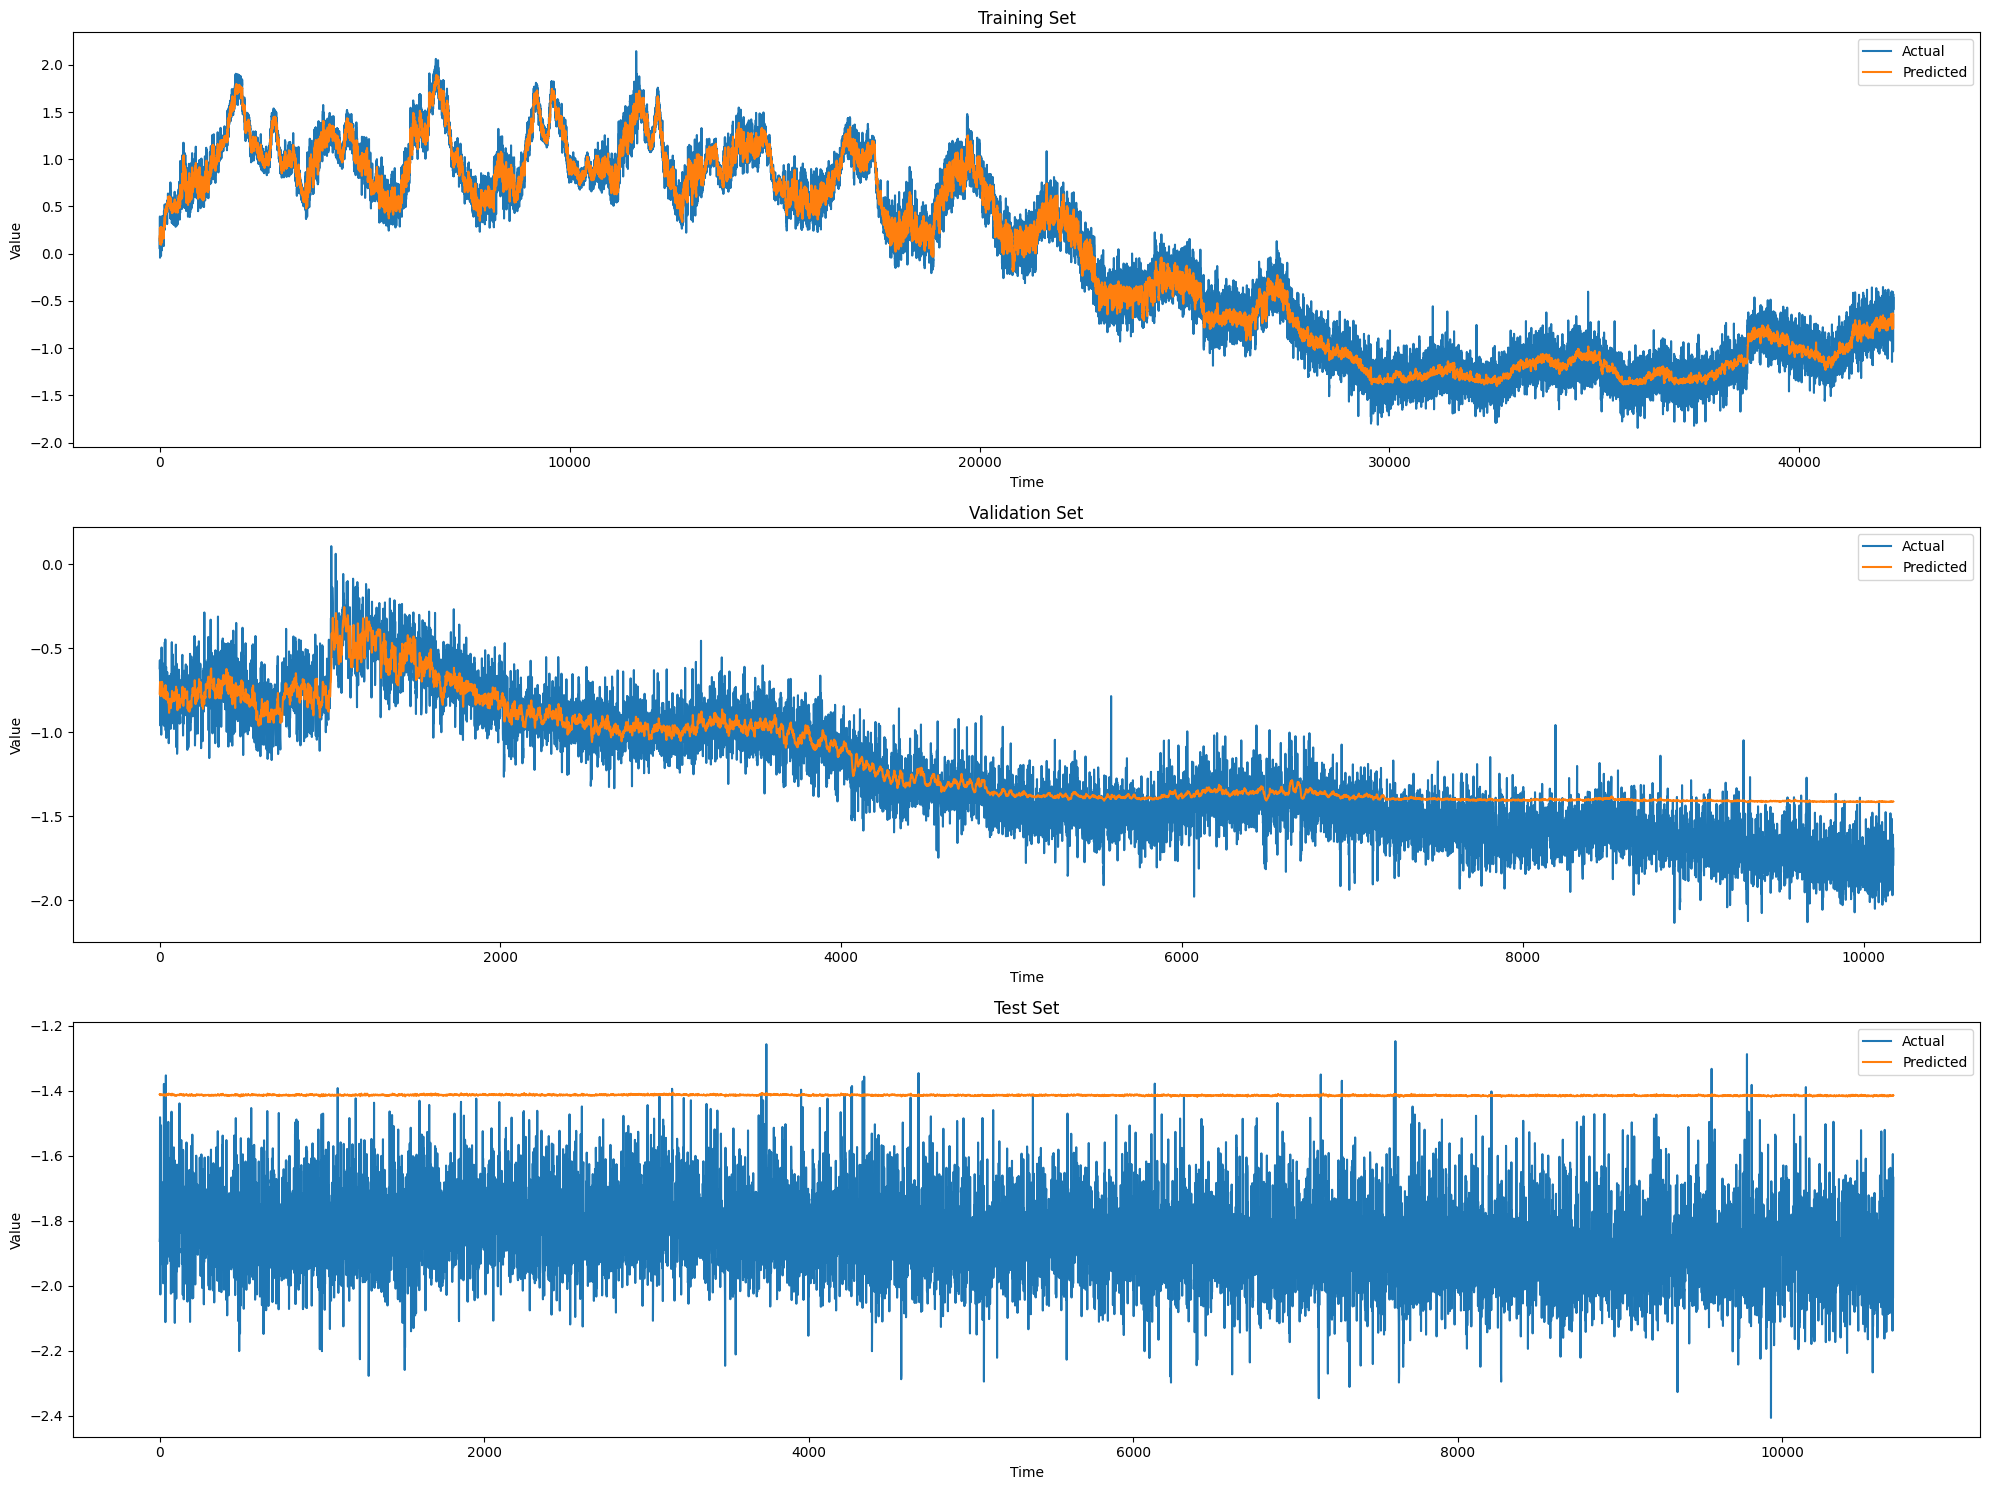

In [ ]:
plot_results(X_train,X_val,X_test,y_train,y_val,y_test, lstm_model_d)

In [ ]:
lstm_model_2 = Sequential([
    layers.LSTM(120),
    layers.Dense(OUT_STEPS*num_features, kernel_initializer = tf.initializers.zeros()),

    layers.Reshape([OUT_STEPS, num_features])
])

lstm_model_2.build((None, 15, 1))  # 'None' can be used for batch size flexibility
lstm_model_2.summary()  # Now this should work without throwing an error

lstm_model_2.compile(loss='mse',
              optimizer=Adam(learning_rate=0.001),
              metrics=['mean_absolute_percentage_error'])

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 120)               58560     
                                                                 
 dense_4 (Dense)             (None, 5)                 605       
                                                                 
 reshape_4 (Reshape)         (None, 5, 1)              0         
                                                                 
Total params: 59165 (231.11 KB)
Trainable params: 59165 (231.11 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
history = lstm_model_2.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)]
)

Epoch 1/100
1322/1322 [==============================] - 30s 21ms/step - loss: 0.0302 - mean_absolute_percentage_error: 48.8458 - val_loss: 0.0228 - val_mean_absolute_percentage_error: 12.6858
Epoch 2/100
1322/1322 [==============================] - 27s 20ms/step - loss: 0.0167 - mean_absolute_percentage_error: 42.6788 - val_loss: 0.0222 - val_mean_absolute_percentage_error: 12.0146
Epoch 3/100
1322/1322 [==============================] - 28s 21ms/step - loss: 0.0165 - mean_absolute_percentage_error: 42.1396 - val_loss: 0.0218 - val_mean_absolute_percentage_error: 11.5844
Epoch 4/100
1322/1322 [==============================] - 27s 20ms/step - loss: 0.0165 - mean_absolute_percentage_error: 42.0538 - val_loss: 0.0216 - val_mean_absolute_percentage_error: 11.8454
Epoch 5/100
1322/1322 [==============================] - 27s 21ms/step - loss: 0.0163 - mean_absolute_percentage_error: 41.9210 - val_loss: 0.0266 - val_mean_absolute_percentage_error: 12.2235
Epoch 6/100
1322/1322 [============

334/334 [==============================] - 3s 8ms/step


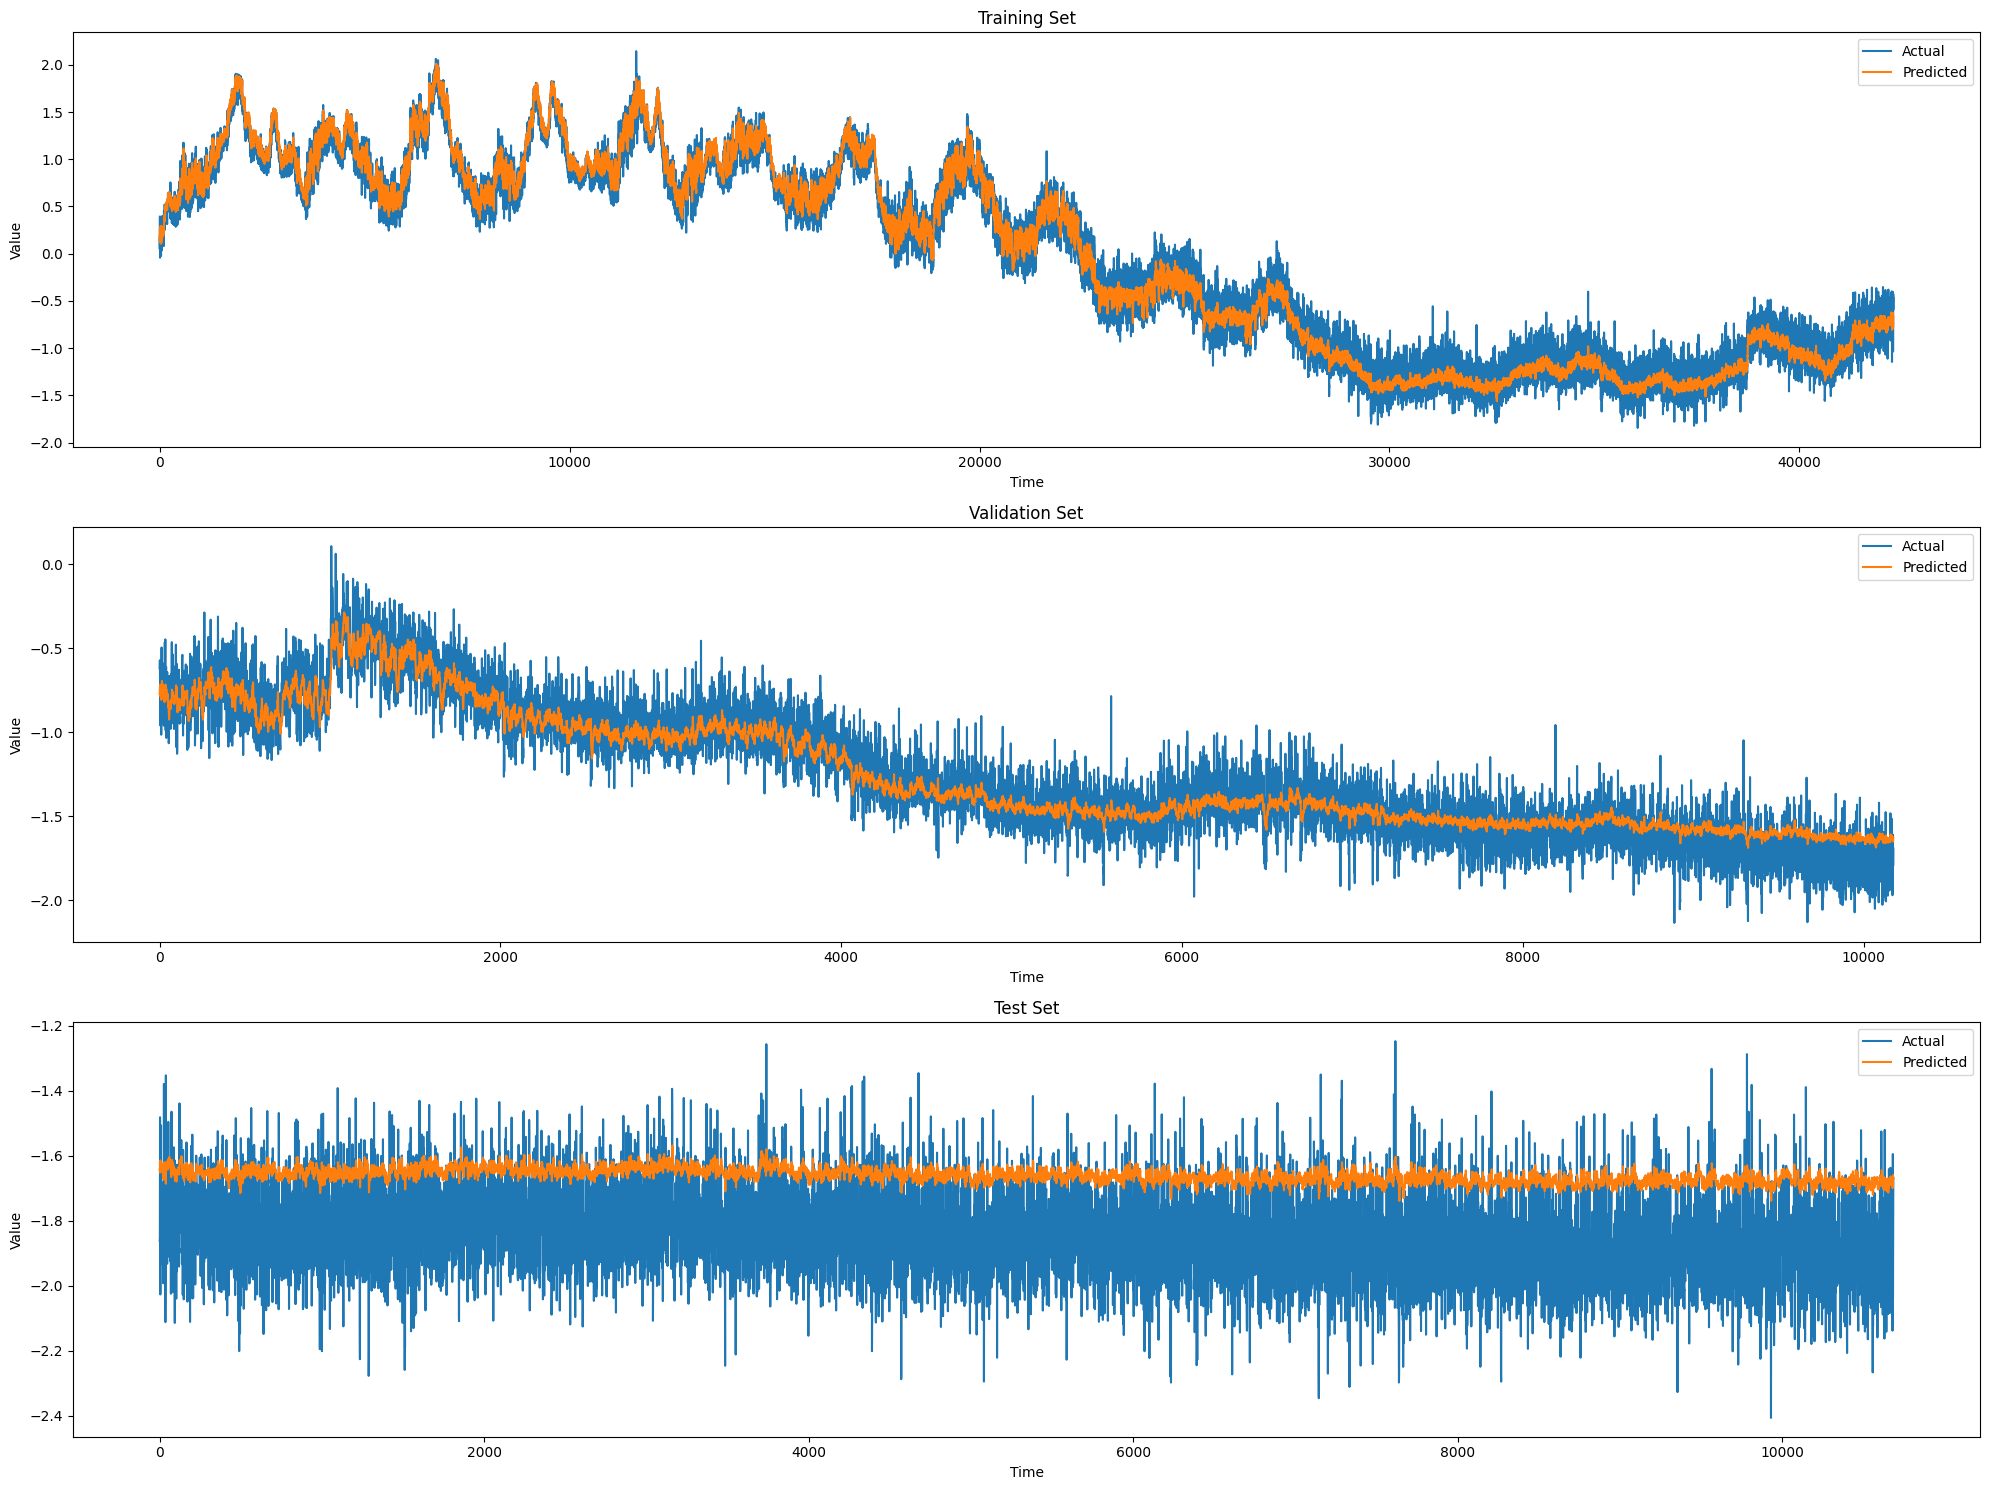

In [ ]:
plot_results(X_train,X_val,X_test,y_train,y_val,y_test, lstm_model_2)

In [ ]:
lstm_model_3 = Sequential([
    layers.LSTM(256),
    layers.Dense(OUT_STEPS*num_features, kernel_initializer = tf.initializers.zeros()),

    layers.Reshape([OUT_STEPS, num_features])
])

lstm_model_3.build((None, 15, 1))  # 'None' can be used for batch size flexibility
lstm_model_3.summary()  # Now this should work without throwing an error

lstm_model_3.compile(loss='mse',
              optimizer=Adam(learning_rate=0.001),
              metrics=['mean_absolute_percentage_error'])

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_7 (LSTM)               (None, 256)               264192    
                                                                 
 dense_5 (Dense)             (None, 5)                 1285      
                                                                 
 reshape_5 (Reshape)         (None, 5, 1)              0         
                                                                 
Total params: 265477 (1.01 MB)
Trainable params: 265477 (1.01 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
history = lstm_model_3.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)]
)

Epoch 1/100
1322/1322 [==============================] - 62s 45ms/step - loss: 0.0252 - mean_absolute_percentage_error: 46.3598 - val_loss: 0.0224 - val_mean_absolute_percentage_error: 11.6620
Epoch 2/100
1322/1322 [==============================] - 59s 44ms/step - loss: 0.0169 - mean_absolute_percentage_error: 41.8777 - val_loss: 0.0214 - val_mean_absolute_percentage_error: 11.4496
Epoch 3/100
1322/1322 [==============================] - 58s 44ms/step - loss: 0.0168 - mean_absolute_percentage_error: 41.3548 - val_loss: 0.0263 - val_mean_absolute_percentage_error: 12.1874
Epoch 4/100
1322/1322 [==============================] - 58s 44ms/step - loss: 0.0165 - mean_absolute_percentage_error: 41.7843 - val_loss: 0.0217 - val_mean_absolute_percentage_error: 11.9009
Epoch 5/100
1322/1322 [==============================] - 58s 44ms/step - loss: 0.0164 - mean_absolute_percentage_error: 41.6811 - val_loss: 0.0222 - val_mean_absolute_percentage_error: 11.8849
Epoch 6/100
1322/1322 [============

334/334 [==============================] - 6s 17ms/step


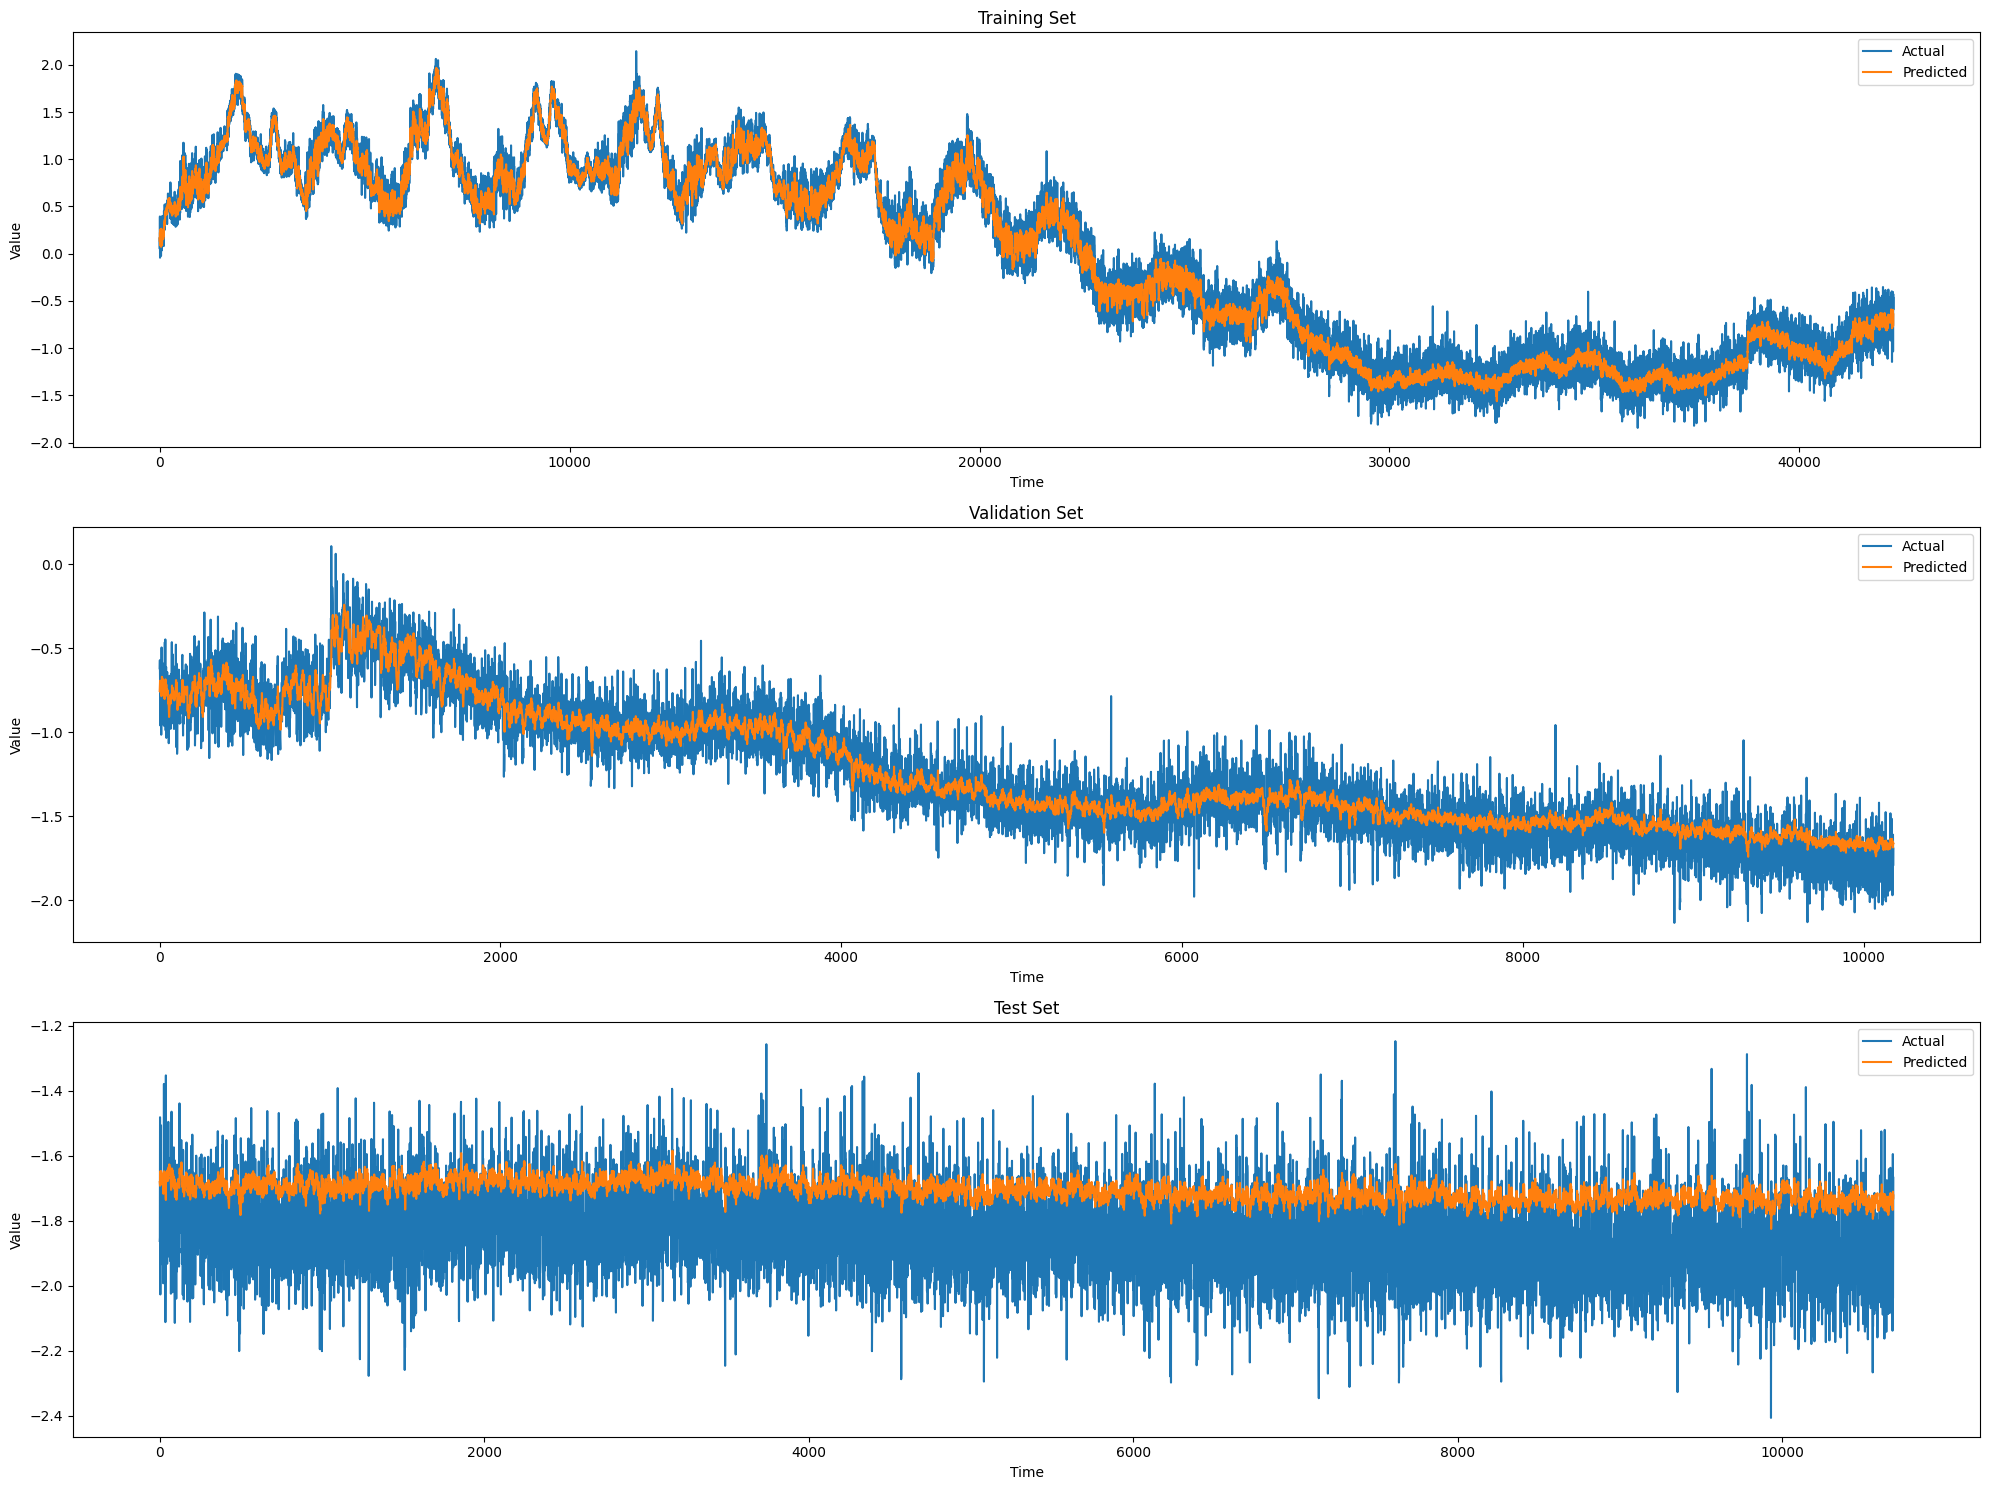

In [ ]:
plot_results(X_train,X_val,X_test,y_train,y_val,y_test, lstm_model_3)

In [15]:
lstm_model_4 = Sequential([
    layers.LSTM(200),
    layers.Dense(OUT_STEPS*num_features, kernel_initializer = tf.initializers.zeros()),

    layers.Reshape([OUT_STEPS, num_features])
])

lstm_model_4.build((None, 15, 1))  # 'None' can be used for batch size flexibility
lstm_model_4.summary()  # Now this should work without throwing an error

lstm_model_4.compile(loss='mse',
              optimizer=Adam(learning_rate=0.001),
              metrics=['mean_absolute_percentage_error'])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 200)               161600    
                                                                 
 dense_1 (Dense)             (None, 5)                 1005      
                                                                 
 reshape_1 (Reshape)         (None, 5, 1)              0         
                                                                 
Total params: 162605 (635.18 KB)
Trainable params: 162605 (635.18 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [16]:
history = lstm_model_4.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)]
)

Epoch 1/100
1322/1322 [==============================] - 44s 31ms/step - loss: 0.0292 - mean_absolute_percentage_error: 47.2435 - val_loss: 0.0227 - val_mean_absolute_percentage_error: 11.8541
Epoch 2/100
1322/1322 [==============================] - 38s 28ms/step - loss: 0.0169 - mean_absolute_percentage_error: 41.9675 - val_loss: 0.0222 - val_mean_absolute_percentage_error: 11.6039
Epoch 3/100
1322/1322 [==============================] - 40s 30ms/step - loss: 0.0165 - mean_absolute_percentage_error: 42.0740 - val_loss: 0.0264 - val_mean_absolute_percentage_error: 12.1205
Epoch 4/100
1322/1322 [==============================] - 37s 28ms/step - loss: 0.0165 - mean_absolute_percentage_error: 41.9542 - val_loss: 0.0239 - val_mean_absolute_percentage_error: 12.2600
Epoch 5/100
1322/1322 [==============================] - 38s 29ms/step - loss: 0.0164 - mean_absolute_percentage_error: 41.8822 - val_loss: 0.0238 - val_mean_absolute_percentage_error: 12.1236
Epoch 6/100
1322/1322 [============

334/334 [==============================] - 4s 13ms/step


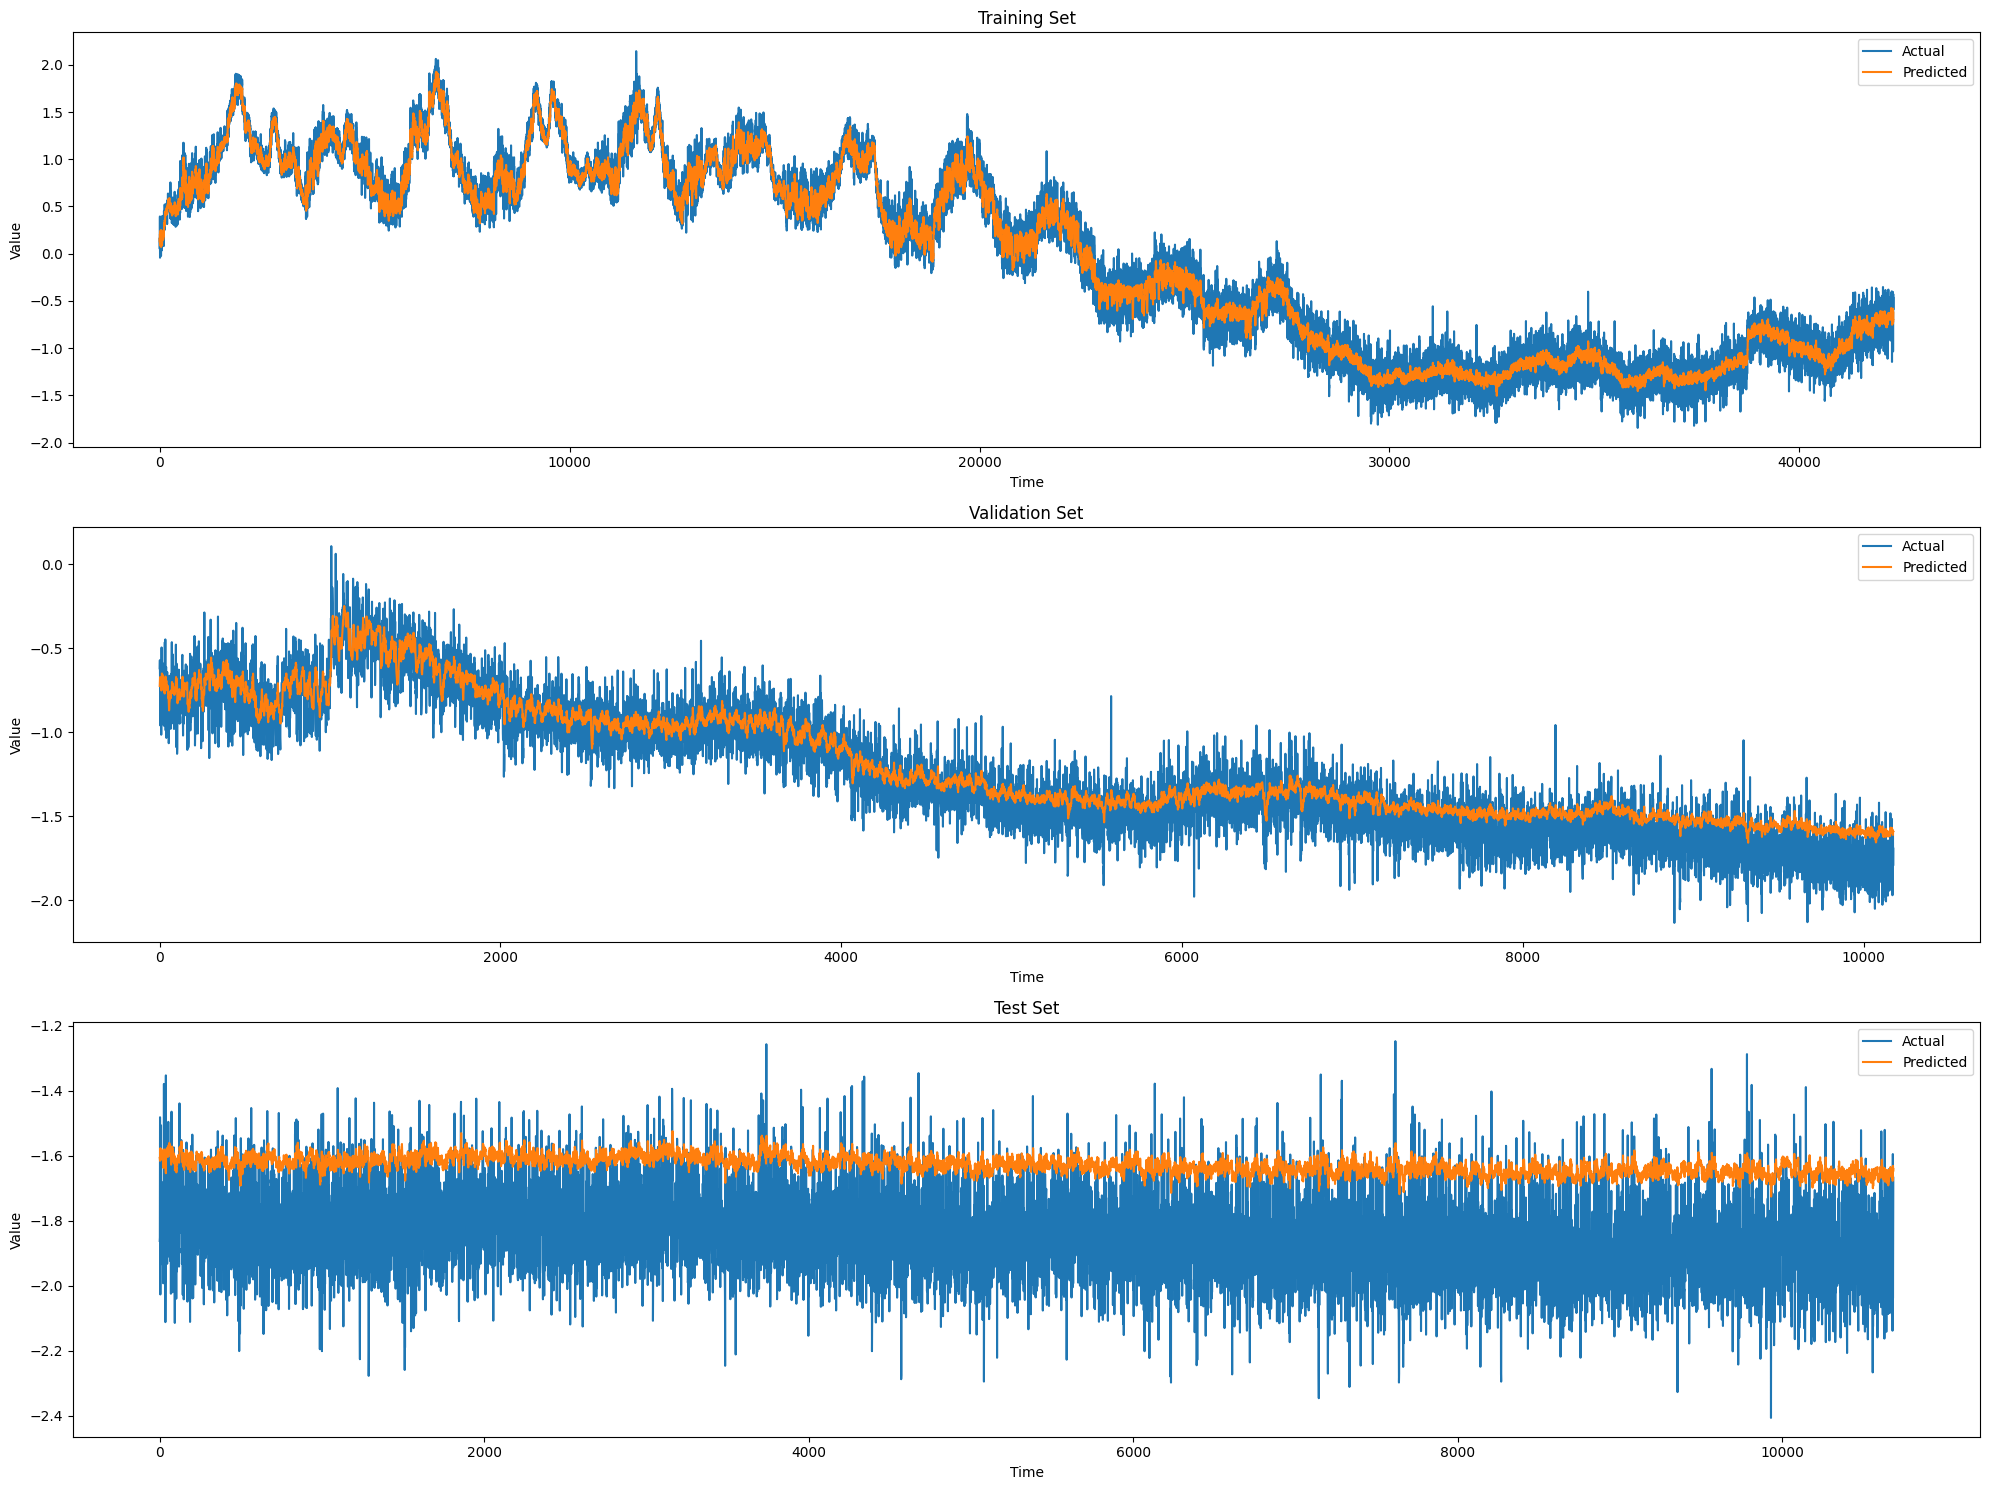

In [19]:
plot_results(X_train,X_val,X_test,y_train,y_val,y_test, lstm_model_4)

In [20]:
# Simpler structure

lstm_model_5 = Sequential([
    layers.LSTM(64),
    layers.Dense(OUT_STEPS*num_features, kernel_initializer = tf.initializers.zeros()),

    layers.Reshape([OUT_STEPS, num_features])
])

lstm_model_5.build((None, 15, 1))  # 'None' can be used for batch size flexibility
lstm_model_5.summary()  # Now this should work without throwing an error

lstm_model_5.compile(loss='mse',
              optimizer=Adam(learning_rate=0.001),
              metrics=['mean_absolute_percentage_error'])

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 64)                16896     
                                                                 
 dense_2 (Dense)             (None, 5)                 325       
                                                                 
 reshape_2 (Reshape)         (None, 5, 1)              0         
                                                                 
Total params: 17221 (67.27 KB)
Trainable params: 17221 (67.27 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [21]:
history = lstm_model_5.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)]
)

Epoch 1/100
1322/1322 [==============================] - 18s 12ms/step - loss: 0.0345 - mean_absolute_percentage_error: 47.3575 - val_loss: 0.0241 - val_mean_absolute_percentage_error: 11.8910
Epoch 2/100
1322/1322 [==============================] - 15s 12ms/step - loss: 0.0166 - mean_absolute_percentage_error: 42.4794 - val_loss: 0.0250 - val_mean_absolute_percentage_error: 11.9280
Epoch 3/100
1322/1322 [==============================] - 15s 11ms/step - loss: 0.0164 - mean_absolute_percentage_error: 42.5998 - val_loss: 0.0228 - val_mean_absolute_percentage_error: 11.6949
Epoch 4/100
1322/1322 [==============================] - 15s 11ms/step - loss: 0.0163 - mean_absolute_percentage_error: 42.2570 - val_loss: 0.0238 - val_mean_absolute_percentage_error: 11.6686
Epoch 5/100
1322/1322 [==============================] - 15s 12ms/step - loss: 0.0162 - mean_absolute_percentage_error: 42.3154 - val_loss: 0.0250 - val_mean_absolute_percentage_error: 12.0786
Epoch 6/100
1322/1322 [============

KeyboardInterrupt: 

In [22]:
lstm_model_6 = Sequential([
    layers.LSTM(64, return_sequences=True),
    layers.LSTM(32),
    layers.Dense(OUT_STEPS*num_features, kernel_initializer = tf.initializers.zeros()),

    layers.Reshape([OUT_STEPS, num_features])
])

lstm_model_6.build((None, 15, 1))  # 'None' can be used for batch size flexibility
lstm_model_6.summary()  # Now this should work without throwing an error

lstm_model_6.compile(loss='mse',
              optimizer=Adam(learning_rate=0.001),
              metrics=['mean_absolute_percentage_error'])

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 15, 64)            16896     
                                                                 
 lstm_4 (LSTM)               (None, 32)                12416     
                                                                 
 dense_3 (Dense)             (None, 5)                 165       
                                                                 
 reshape_3 (Reshape)         (None, 5, 1)              0         
                                                                 
Total params: 29477 (115.14 KB)
Trainable params: 29477 (115.14 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [23]:
history = lstm_model_6.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)]
)

Epoch 1/100
1322/1322 [==============================] - 31s 20ms/step - loss: 0.0379 - mean_absolute_percentage_error: 48.8082 - val_loss: 0.0279 - val_mean_absolute_percentage_error: 12.4176
Epoch 2/100
1322/1322 [==============================] - 25s 19ms/step - loss: 0.0168 - mean_absolute_percentage_error: 44.0603 - val_loss: 0.0242 - val_mean_absolute_percentage_error: 12.0195
Epoch 3/100
1322/1322 [==============================] - 26s 19ms/step - loss: 0.0165 - mean_absolute_percentage_error: 43.6749 - val_loss: 0.0238 - val_mean_absolute_percentage_error: 11.7864
Epoch 4/100
1322/1322 [==============================] - 26s 19ms/step - loss: 0.0163 - mean_absolute_percentage_error: 43.3584 - val_loss: 0.0240 - val_mean_absolute_percentage_error: 11.9129
Epoch 5/100
1322/1322 [==============================] - 26s 20ms/step - loss: 0.0162 - mean_absolute_percentage_error: 42.6270 - val_loss: 0.0256 - val_mean_absolute_percentage_error: 12.1911
Epoch 6/100
1322/1322 [============

KeyboardInterrupt: 

In [26]:
# same structure without drop out

lstm_model_7 = Sequential([
    layers.LSTM(150, return_sequences=True),
    layers.LSTM(32),
    layers.Dense(OUT_STEPS*num_features, kernel_initializer = tf.initializers.zeros()),

    layers.Reshape([OUT_STEPS, num_features])
])

lstm_model_7.build((None, 20, 1))  # 'None' can be used for batch size flexibility
lstm_model_7.summary()  # Now this should work without throwing an error

lstm_model_7.compile(loss='mse',
              optimizer=Adam(learning_rate=0.001),
              metrics=['mean_absolute_percentage_error'])

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_7 (LSTM)               (None, 20, 150)           91200     
                                                                 
 lstm_8 (LSTM)               (None, 32)                23424     
                                                                 
 dense_5 (Dense)             (None, 5)                 165       
                                                                 
 reshape_5 (Reshape)         (None, 5, 1)              0         
                                                                 
Total params: 114789 (448.39 KB)
Trainable params: 114789 (448.39 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [27]:
history = lstm_model_7.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)]
)

Epoch 1/100
1322/1322 [==============================] - 48s 34ms/step - loss: 0.0356 - mean_absolute_percentage_error: 49.6002 - val_loss: 0.0253 - val_mean_absolute_percentage_error: 12.4380
Epoch 2/100
1322/1322 [==============================] - 43s 33ms/step - loss: 0.0169 - mean_absolute_percentage_error: 43.6158 - val_loss: 0.0295 - val_mean_absolute_percentage_error: 13.1663
Epoch 3/100
1322/1322 [==============================] - 42s 32ms/step - loss: 0.0164 - mean_absolute_percentage_error: 42.7965 - val_loss: 0.0248 - val_mean_absolute_percentage_error: 12.2440
Epoch 4/100
1322/1322 [==============================] - 42s 32ms/step - loss: 0.0163 - mean_absolute_percentage_error: 42.1957 - val_loss: 0.0254 - val_mean_absolute_percentage_error: 12.0490
Epoch 5/100
1322/1322 [==============================] - 42s 32ms/step - loss: 0.0162 - mean_absolute_percentage_error: 42.3835 - val_loss: 0.0262 - val_mean_absolute_percentage_error: 12.0147
Epoch 6/100
1322/1322 [============

In [29]:
lstm_model_8 = Sequential([
    layers.LSTM(64, return_sequences=True),
    layers.LSTM(32, return_sequences= True),
    layers.LSTM(16),
    layers.Dense(OUT_STEPS*num_features, kernel_initializer = tf.initializers.zeros()),

    layers.Reshape([OUT_STEPS, num_features])
])

lstm_model_8.build((None, 20, 1))  # 'None' can be used for batch size flexibility
lstm_model_8.summary()  # Now this should work without throwing an error

lstm_model_8.compile(loss='mse',
              optimizer=Adam(learning_rate=0.001),
              metrics=['mean_absolute_percentage_error'])

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_12 (LSTM)              (None, 20, 64)            16896     
                                                                 
 lstm_13 (LSTM)              (None, 20, 32)            12416     
                                                                 
 lstm_14 (LSTM)              (None, 16)                3136      
                                                                 
 dense_7 (Dense)             (None, 5)                 85        
                                                                 
 reshape_7 (Reshape)         (None, 5, 1)              0         
                                                                 
Total params: 32533 (127.08 KB)
Trainable params: 32533 (127.08 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
history = lstm_model_8.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)]
)

Epoch 1/100
1322/1322 [==============================] - 45s 29ms/step - loss: 0.0504 - mean_absolute_percentage_error: 50.8217 - val_loss: 0.0295 - val_mean_absolute_percentage_error: 13.1382
Epoch 2/100
1322/1322 [==============================] - 38s 29ms/step - loss: 0.0168 - mean_absolute_percentage_error: 44.2029 - val_loss: 0.0287 - val_mean_absolute_percentage_error: 12.5000
Epoch 3/100
1322/1322 [==============================] - 35s 26ms/step - loss: 0.0165 - mean_absolute_percentage_error: 44.1786 - val_loss: 0.0278 - val_mean_absolute_percentage_error: 12.4947
Epoch 4/100
1322/1322 [==============================] - 35s 27ms/step - loss: 0.0163 - mean_absolute_percentage_error: 43.5360 - val_loss: 0.0282 - val_mean_absolute_percentage_error: 12.4024
Epoch 5/100
1322/1322 [==============================] - 35s 27ms/step - loss: 0.0162 - mean_absolute_percentage_error: 43.2233 - val_loss: 0.0308 - val_mean_absolute_percentage_error: 12.7160
Epoch 6/100
1322/1322 [============

In [ ]:
lstm_model_9 = Sequential([
    layers.LSTM(160),
    layers.Dense(OUT_STEPS*num_features, kernel_initializer = tf.initializers.zeros()),

    layers.Reshape([OUT_STEPS, num_features])
])

lstm_model_8.build((None, 20, 1))  # 'None' can be used for batch size flexibility
lstm_model_8.summary()  # Now this should work without throwing an error

lstm_model_8.compile(loss='mse',
              optimizer=Adam(learning_rate=0.001),
              metrics=['mean_absolute_percentage_error'])

In [ ]:
y_val_x = np.arange(len(y_val))

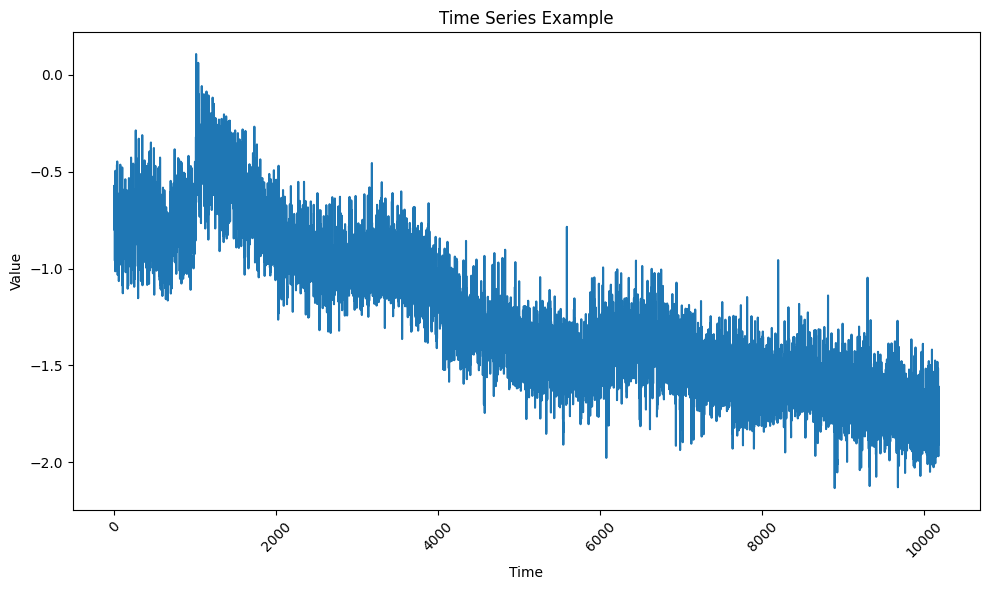

In [ ]:
plt.figure(figsize=(10, 6))  # Optionally set the figure size
plt.plot(y_val_x, y_val[:,0])  # Plot the time series data
plt.title('Time Series Example')  # Add a title
plt.xlabel('Time')  # Label the x-axis
plt.ylabel('Value')  # Label the y-axis
plt.xticks(rotation=45)  # Rotate date labels for better readability
plt.tight_layout()  # Automatically adjust subplot parameters to give specified padding
plt.show()

In [ ]:
pred_val = lstm_model_0.predict(X_val)

319/319 [==============================] - 2s 4ms/step


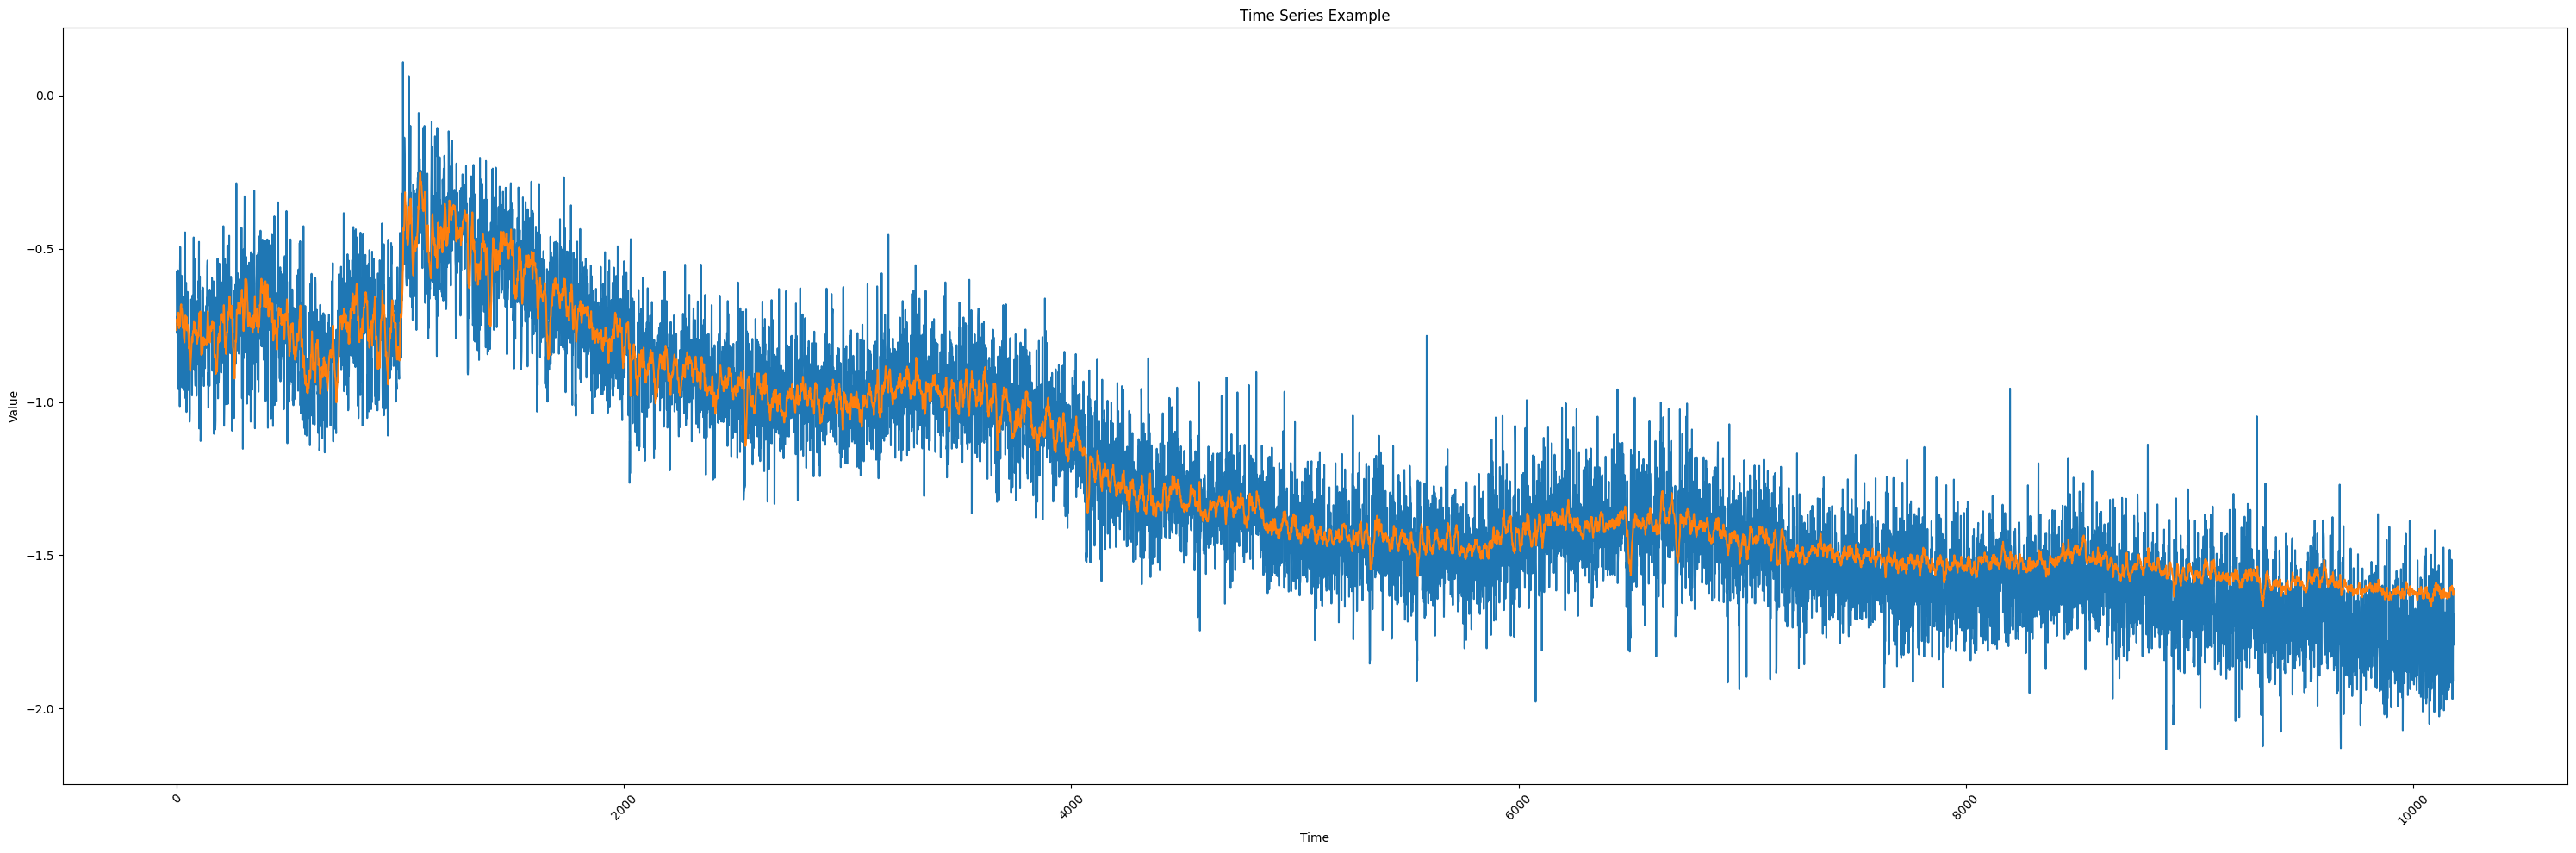

In [ ]:
plt.figure(figsize=(30, 10))  # Optionally set the figure size
plt.plot(y_val_x, y_val[:,0])  # Plot the time series data
plt.plot(y_val_x, pred_val[:,0])
plt.title('Time Series Example')  # Add a title
plt.xlabel('Time')  # Label the x-axis
plt.ylabel('Value')  # Label the y-axis
plt.xticks(rotation=45)  # Rotate date labels for better readability
plt.tight_layout()  # Automatically adjust subplot parameters to give specified padding
plt.show()

In [ ]:
# see the performance on test set

pred_test = lstm_model_0.predict(X_test)

335/335 [==============================] - 2s 5ms/step


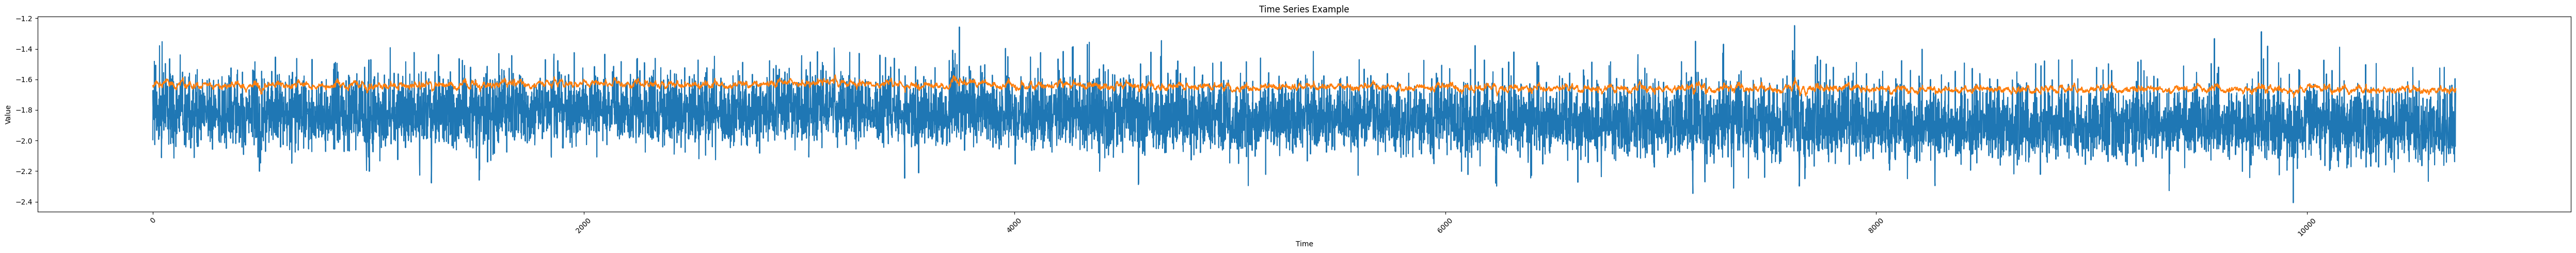

In [ ]:
y_test_x = np.arange(len(y_test))

plt.figure(figsize=(50, 5))  # Optionally set the figure size
plt.plot(y_test_x, y_test[:,0])  # Plot the time series data
plt.plot(y_test_x, pred_test[:,0])
plt.title('Time Series Example')  # Add a title
plt.xlabel('Time')  # Label the x-axis
plt.ylabel('Value')  # Label the y-axis
plt.xticks(rotation=45)  # Rotate date labels for better readability
plt.tight_layout()  # Automatically adjust subplot parameters to give specified padding
plt.show()

1322/1322 [==============================] - 4s 3ms/step


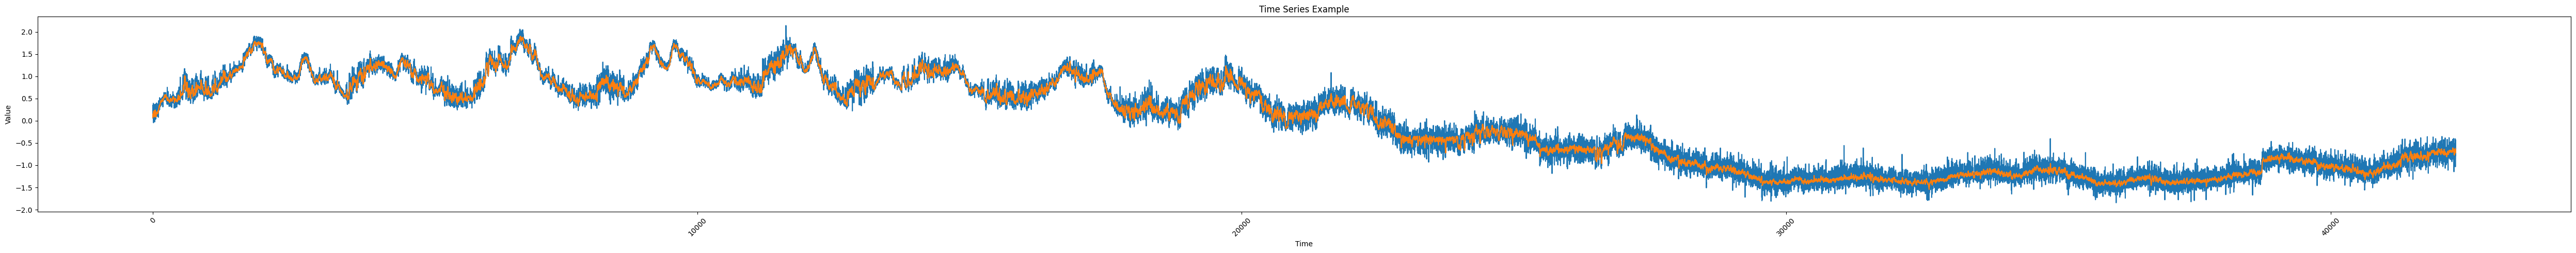

In [ ]:
# performance on train set
pred_train = lstm_model_0.predict(X_train)

y_train_x = np.arange(len(y_train))

plt.figure(figsize=(50, 5))  # Optionally set the figure size
plt.plot(y_train_x, y_train[:,0])  # Plot the time series data
plt.plot(y_train_x, pred_train[:,0])
plt.title('Time Series Example')  # Add a title
plt.xlabel('Time')  # Label the x-axis
plt.ylabel('Value')  # Label the y-axis
plt.xticks(rotation=45)  # Rotate date labels for better readability
plt.tight_layout()  # Automatically adjust subplot parameters to give specified padding
plt.show()

In [ ]:
# create a function that can plot all these graphs in one action
# plot the result on train val and test


def plot_results(X_train,X_val,X_test,y_train,y_val,y_test, model):
    # Creating indices for plotting
    train_x = np.arange(len(y_train))
    val_x = np.arange(len(y_val))
    test_x = np.arange(len(y_test))

    # Making predictions
    pred_train = model.predict(X_train)
    pred_val = model.predict(X_val)
    pred_test = model.predict(X_test)

    # Creating a figure and subplots
    plt.figure(figsize=(20, 15))  # Adjusted for better vertical display

    # Subplot for the training set
    plt.subplot(3, 1, 1)  # 3 rows, 1 column, 1st subplot
    plt.plot(train_x, y_train[:, 0], label='Actual')
    plt.plot(train_x, pred_train[:, 0], label='Predicted')
    plt.title('Training Set')
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.legend()

    # Subplot for the validation set
    plt.subplot(3, 1, 2)  # 3 rows, 1 column, 2nd subplot
    plt.plot(val_x, y_val[:, 0], label='Actual')
    plt.plot(val_x, pred_val[:, 0], label='Predicted')
    plt.title('Validation Set')
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.legend()

    # Subplot for the test set
    plt.subplot(3, 1, 3)  # 3 rows, 1 column, 3rd subplot
    plt.plot(test_x, y_test[:, 0], label='Actual')
    plt.plot(test_x, pred_test[:, 0], label='Predicted')
    plt.title('Test Set')
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.legend()

    # Show plot
    plt.tight_layout()
    plt.show()


335/335 [==============================] - 1s 3ms/step


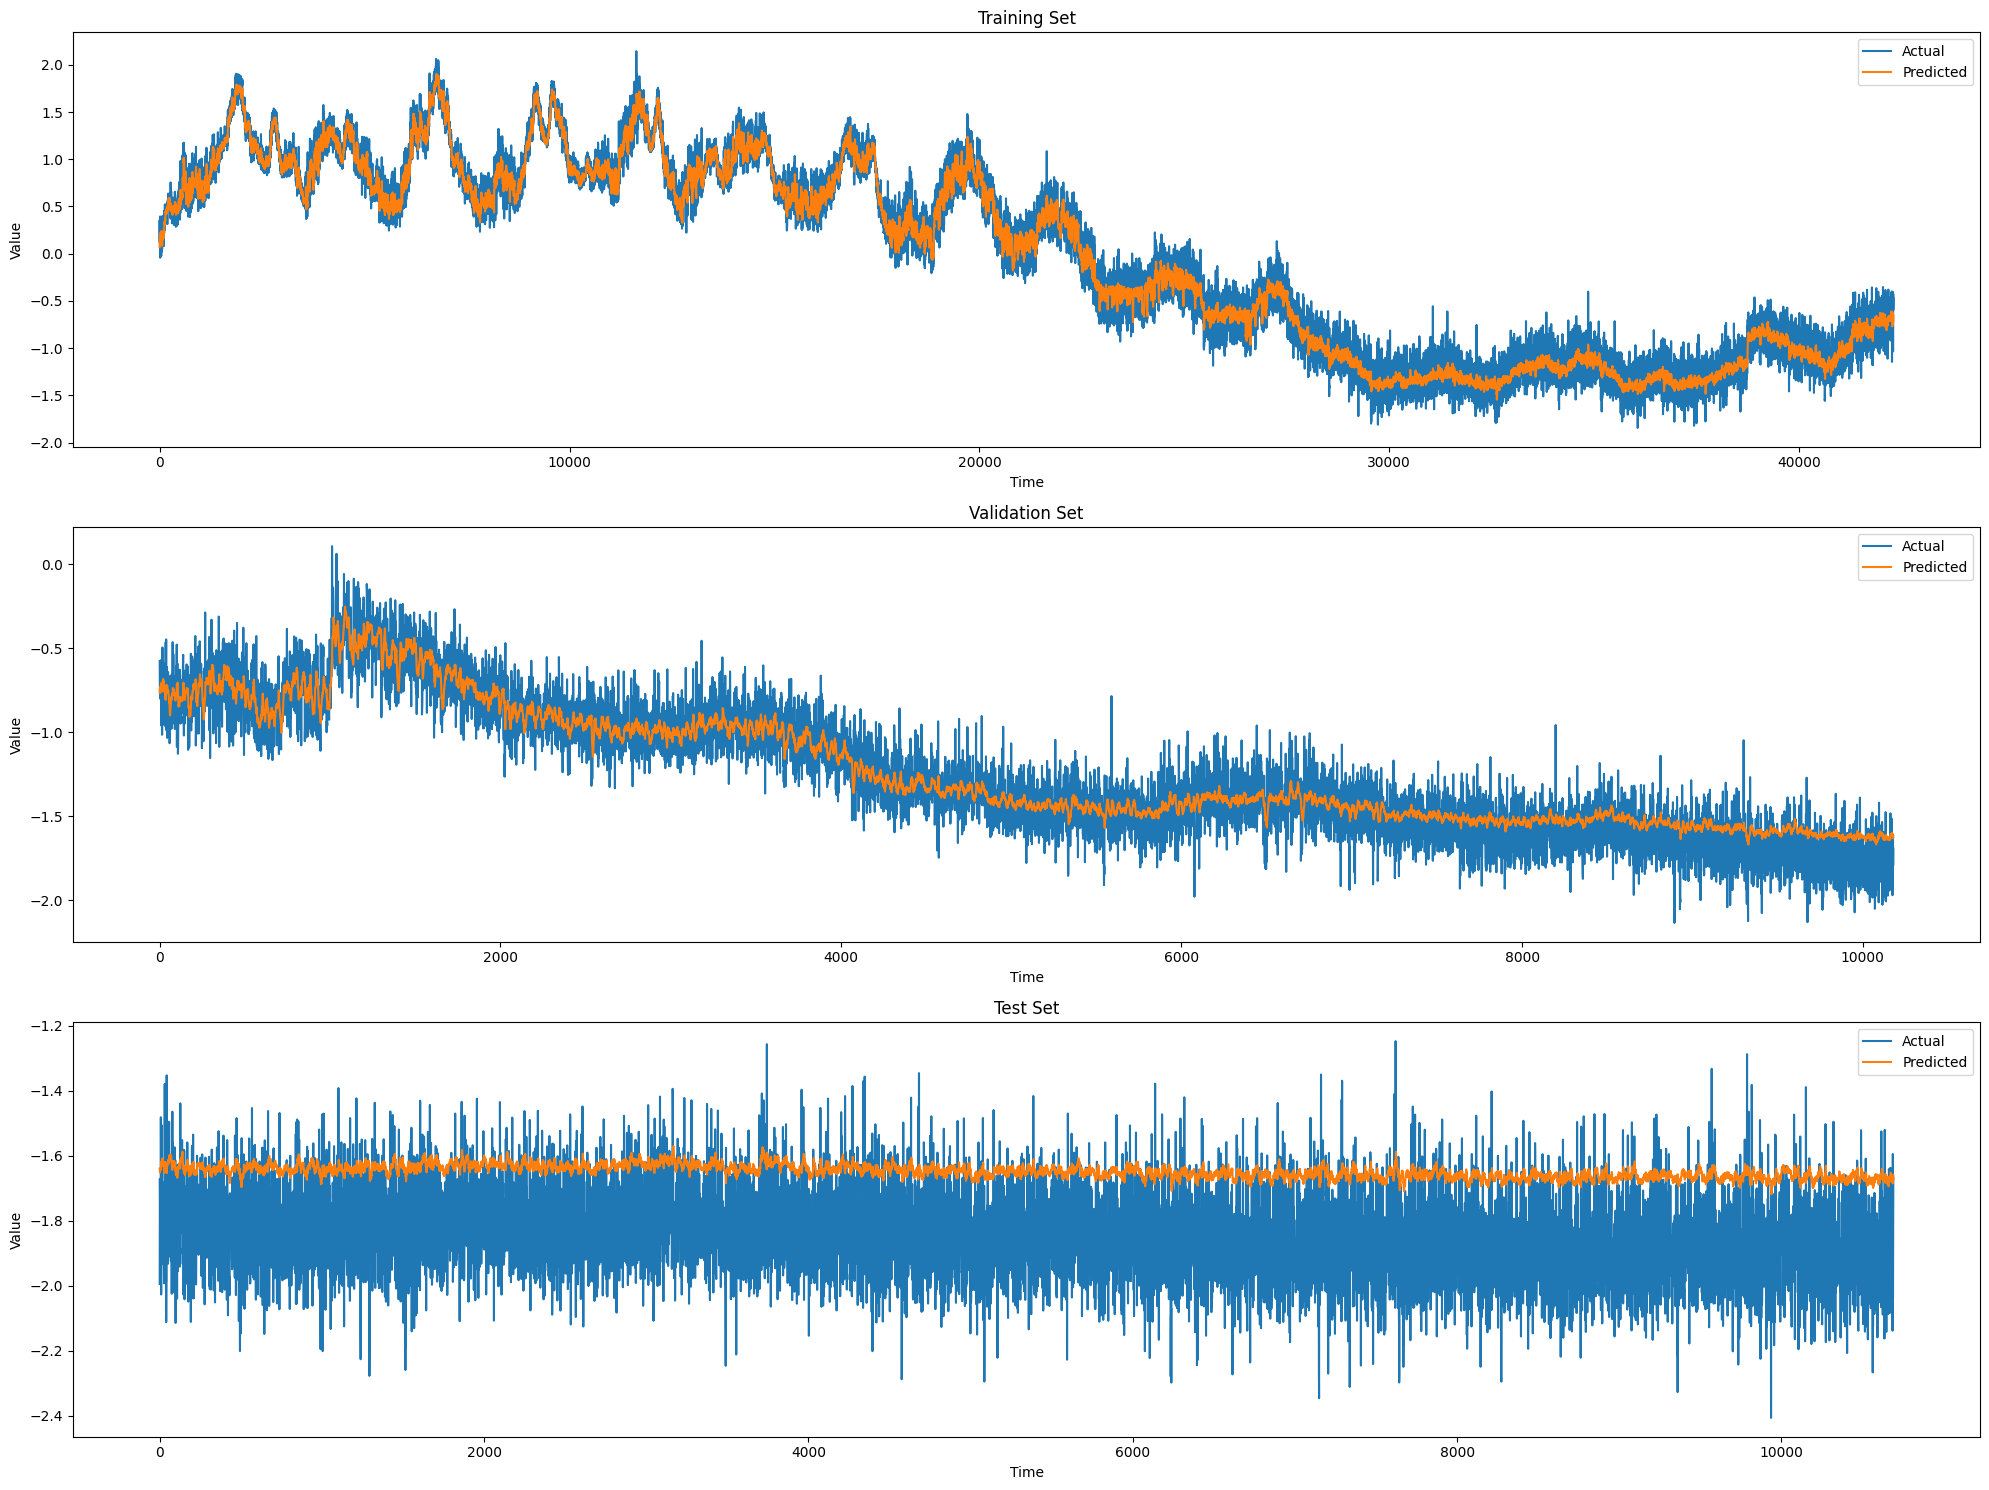

In [ ]:
plot_results(X_train,X_val,X_test,y_train,y_val,y_test, lstm_model_0)

overfitting can be observed

Add dropout in LSTM

In [ ]:
lstm_model_1 = Sequential([
    layers.LSTM(32, dropout=0.5),
    layers.Dense(OUT_STEPS*num_features, kernel_initializer = tf.initializers.zeros()),

    layers.Reshape([OUT_STEPS, num_features])
])

lstm_model_1.build((None, 15, 1))  # 'None' can be used for batch size flexibility
lstm_model_1.summary()  # Now this should work without throwing an error

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (None, 32)                4352      
                                                                 
 dense_8 (Dense)             (None, 5)                 165       
                                                                 
 reshape_8 (Reshape)         (None, 5, 1)              0         
                                                                 
Total params: 4517 (17.64 KB)
Trainable params: 4517 (17.64 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
lstm_model_1.compile(loss='mse',
              optimizer=Adam(learning_rate=0.001),
              metrics=['mean_absolute_percentage_error'])

In [ ]:
history = lstm_model_1.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)]
)

Epoch 1/100
1322/1322 [==============================] - 16s 10ms/step - loss: 0.0615 - mean_absolute_percentage_error: 60.2187 - val_loss: 0.4176 - val_mean_absolute_percentage_error: 44.8701
Epoch 2/100
1322/1322 [==============================] - 13s 9ms/step - loss: 0.0214 - mean_absolute_percentage_error: 50.4320 - val_loss: 0.4708 - val_mean_absolute_percentage_error: 50.2086
Epoch 3/100
1322/1322 [==============================] - 12s 9ms/step - loss: 0.0206 - mean_absolute_percentage_error: 51.7706 - val_loss: 0.4898 - val_mean_absolute_percentage_error: 51.1331
Epoch 4/100
1322/1322 [==============================] - 13s 10ms/step - loss: 0.0199 - mean_absolute_percentage_error: 49.6182 - val_loss: 0.4982 - val_mean_absolute_percentage_error: 52.0563
Epoch 5/100
1322/1322 [==============================] - 13s 9ms/step - loss: 0.0194 - mean_absolute_percentage_error: 49.3841 - val_loss: 0.4680 - val_mean_absolute_percentage_error: 50.1945
Epoch 6/100
1322/1322 [===============

335/335 [==============================] - 1s 3ms/step


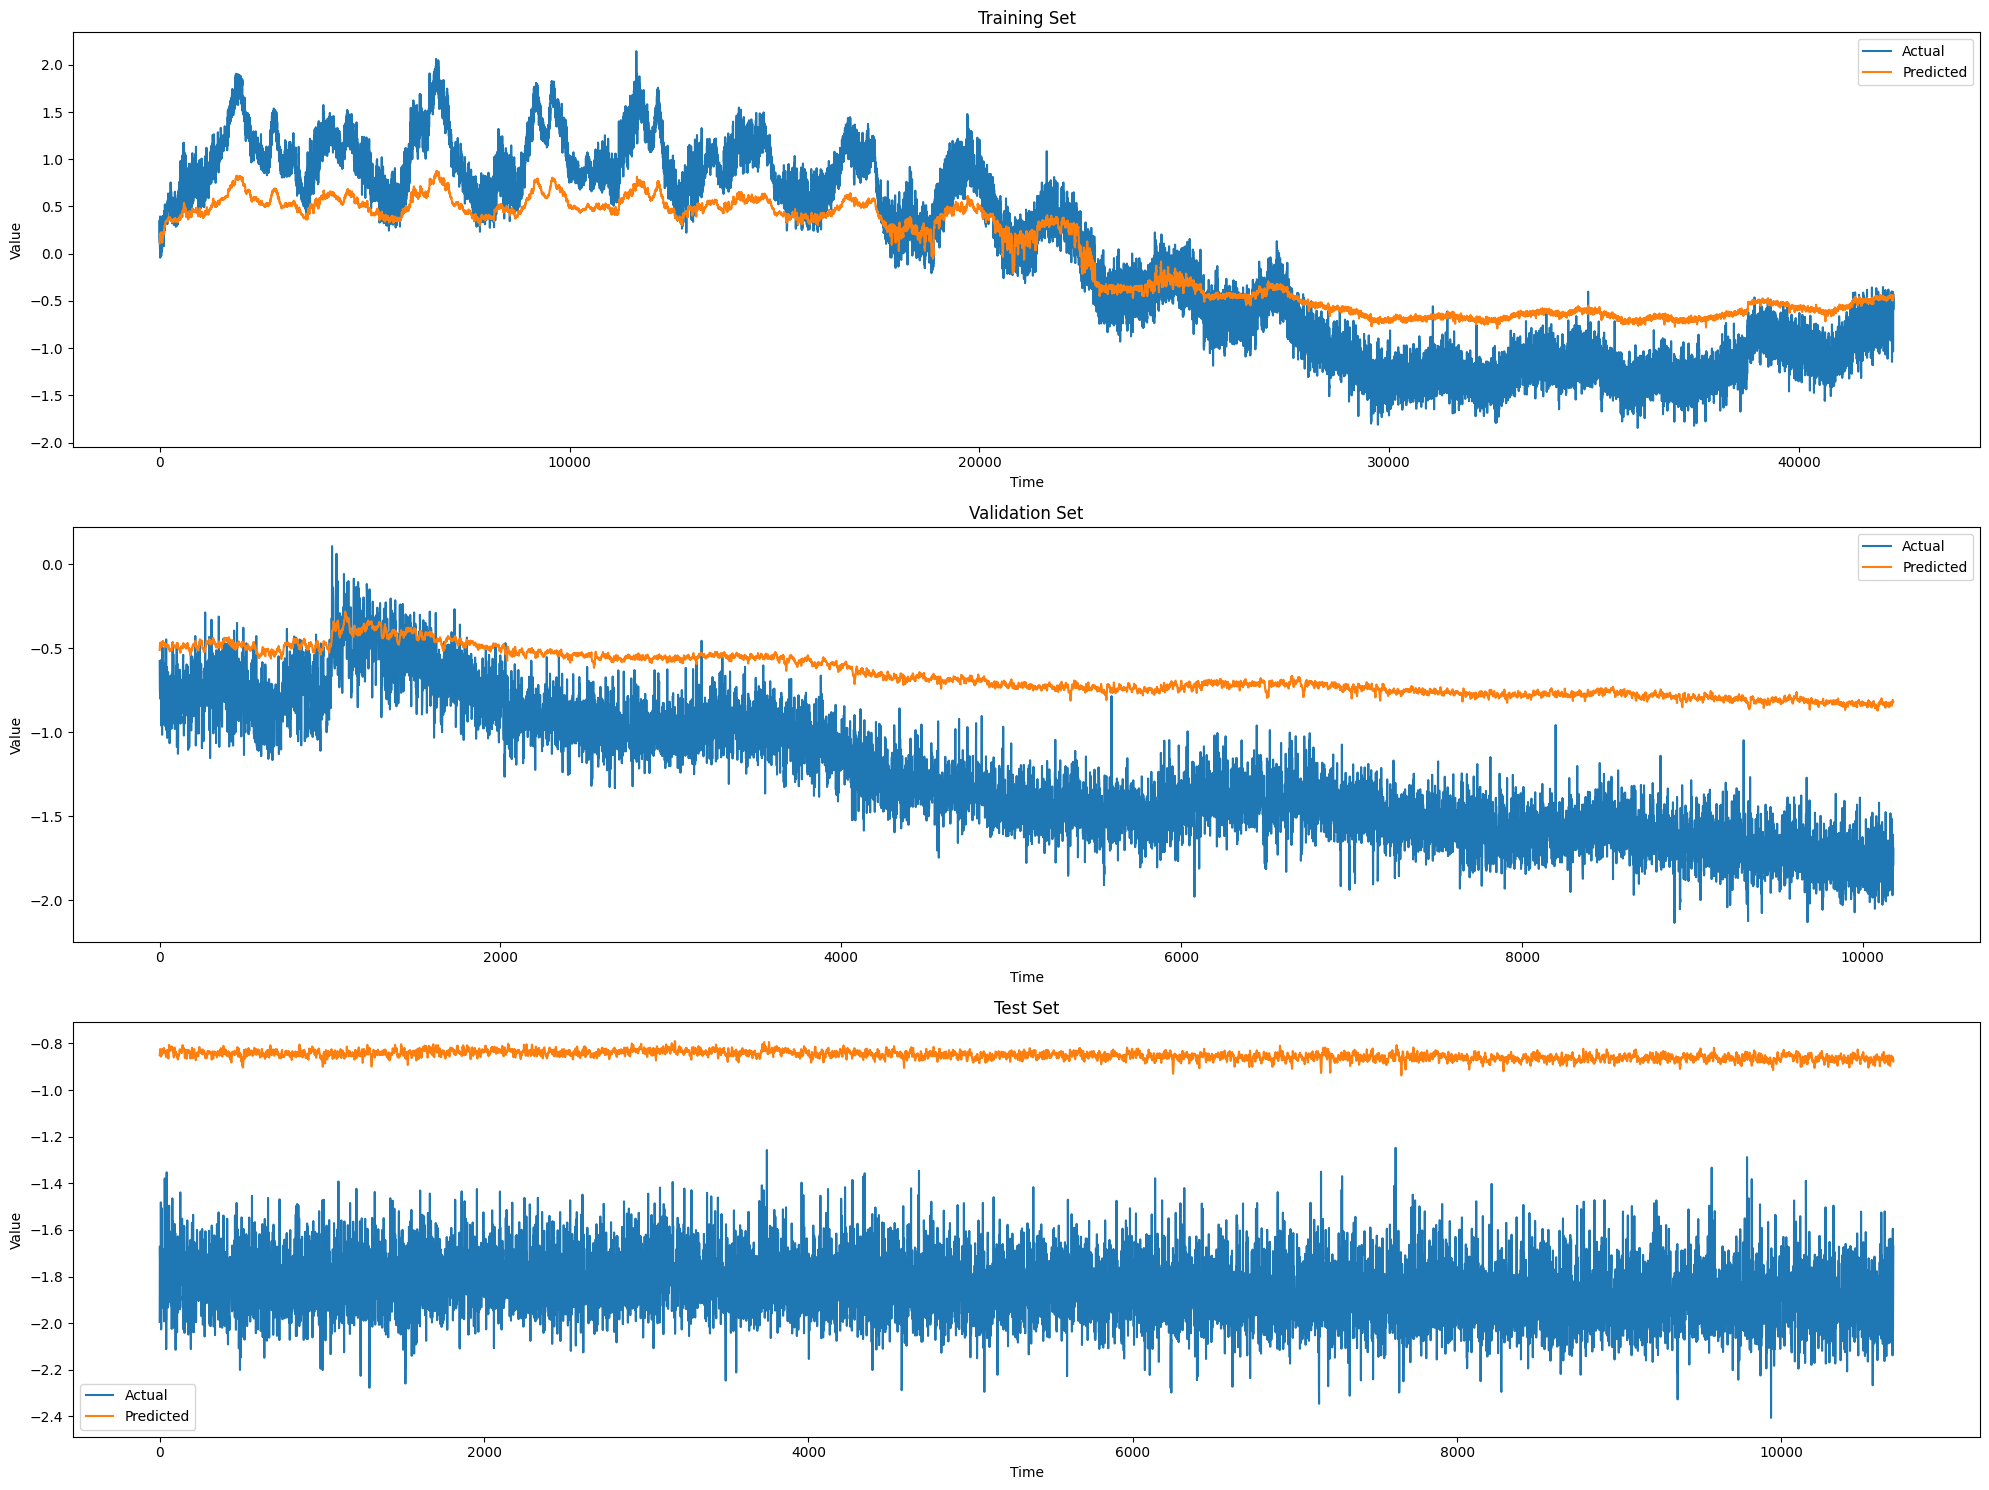

In [ ]:
plot_results(X_train,X_val,X_test,y_train,y_val,y_test, lstm_model_1)

In [ ]:
# more layers

lstm_model_2 = Sequential([
    layers.LSTM(128, return_sequences = True),
    layers.LSTM(64, return_sequences = True),
    layers.LSTM(64, return_sequences = True),
    layers.LSTM(32),
    layers.Dense(OUT_STEPS*num_features, kernel_initializer = tf.initializers.zeros()),

    layers.Reshape([OUT_STEPS, num_features])
])


lstm_model_2.compile(loss='mse',
              optimizer=Adam(learning_rate=0.001),
              metrics=['mean_absolute_percentage_error'])

In [ ]:
history = lstm_model_2.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)]
)

Epoch 1/100
1322/1322 [==============================] - 70s 46ms/step - loss: 0.0405 - mean_absolute_percentage_error: 53.2176 - val_loss: 0.0319 - val_mean_absolute_percentage_error: 13.0431
Epoch 2/100
1322/1322 [==============================] - 58s 44ms/step - loss: 0.0173 - mean_absolute_percentage_error: 44.4280 - val_loss: 0.0286 - val_mean_absolute_percentage_error: 12.3434
Epoch 3/100
1322/1322 [==============================] - 57s 43ms/step - loss: 0.0168 - mean_absolute_percentage_error: 42.9784 - val_loss: 0.0307 - val_mean_absolute_percentage_error: 12.7897
Epoch 4/100
1322/1322 [==============================] - 58s 44ms/step - loss: 0.0167 - mean_absolute_percentage_error: 42.4298 - val_loss: 0.0290 - val_mean_absolute_percentage_error: 12.5149
Epoch 5/100
1322/1322 [==============================] - 59s 45ms/step - loss: 0.0166 - mean_absolute_percentage_error: 42.4864 - val_loss: 0.0335 - val_mean_absolute_percentage_error: 13.1596
Epoch 6/100
1322/1322 [============

335/335 [==============================] - 4s 12ms/step


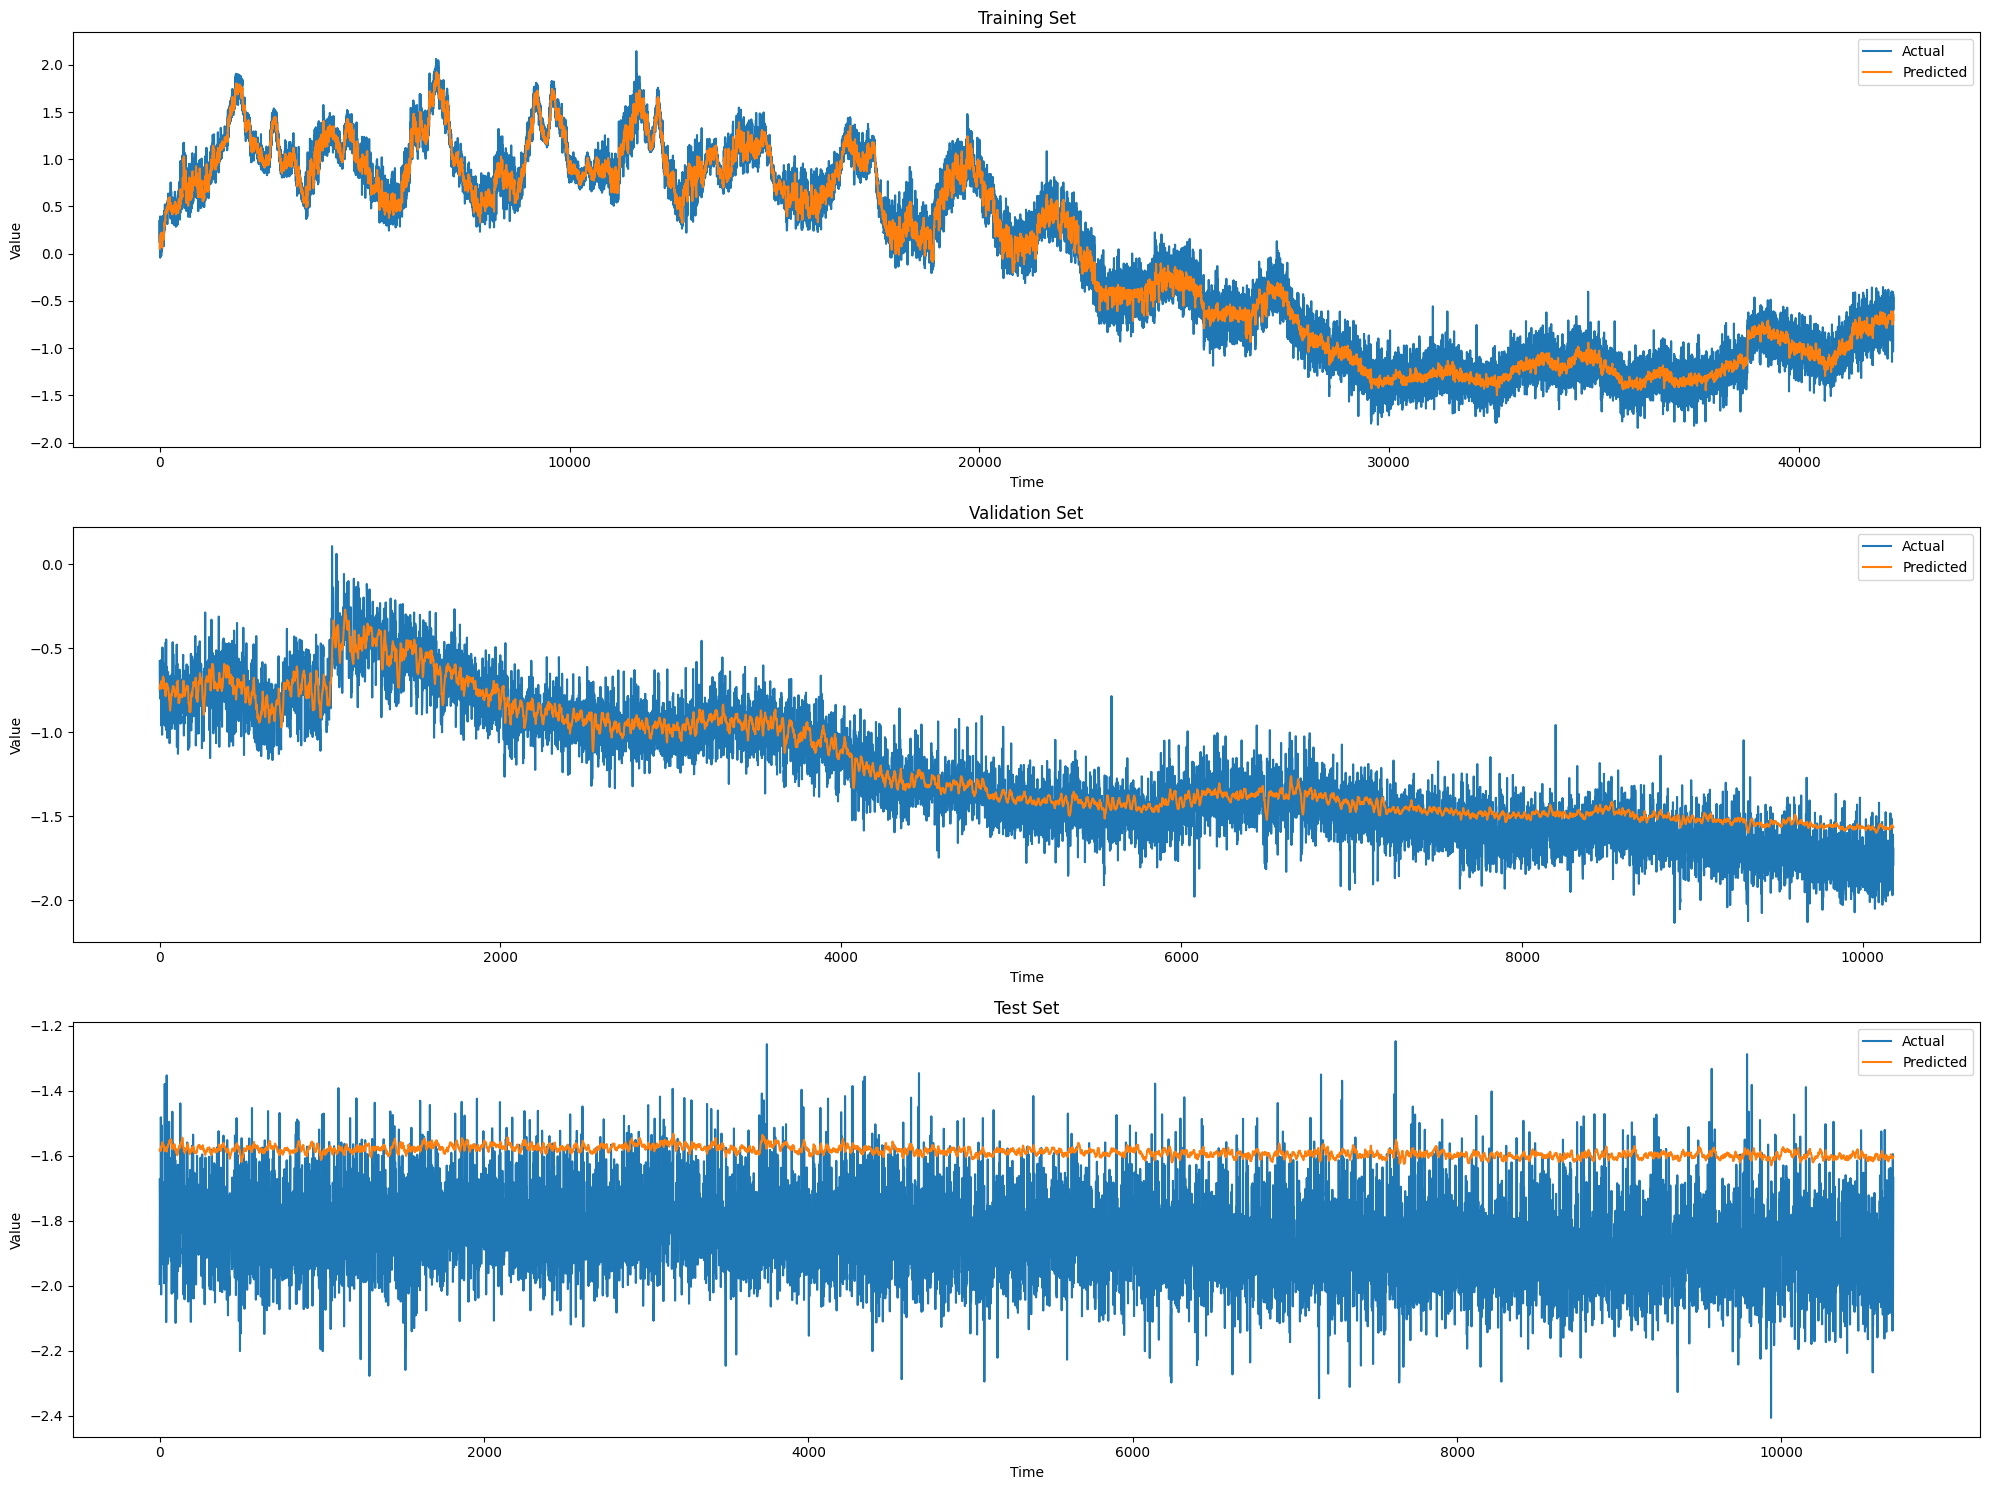

In [ ]:
plot_results(X_train,X_val,X_test,y_train,y_val,y_test, lstm_model_2)